<a href="https://colab.research.google.com/github/xqyn/Modeling/blob/main/PhS_nm_bigQC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Constructing Warped Bayesian Linear Regression normative modeling for big neuroimaging

This notebook provides an analysis discription for constructing Warped Bayesian Linear Regression normative modeling (wBLR) for big neuroimaging dataset.

This notebook are writtein for both Google Colab (linking with drive for private data) and Jupyter Notebok. Only run those lines that corresponding with the chosen environments.

First, if necessary, install PCNtoolkit

In [1]:
%%capture
### Colab
!pip install pcntoolkit==0.21

Set main directortory

In [9]:
# Colab 
wBLR_dir = '/content/'

In [ ]:
%%script false --no-raise-error
# Jupyter
# My directory on linux env
wBLR_dir = '/project_cephfs/3022017.02/projects/xuangu/CamCAN/'

Import the `nm_utils` script files for metrics evaluation

In [5]:
# Import from private GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Colab 
cp /content/drive/MyDrive/wBLR-neuroPCN/scripts/nm_utils.py /content/

In [8]:
%%script false --no-raise-error
# or from git publish link:
import os
! git clone https://github.com/predictive-clinical-neuroscience/braincharts
os.chdir('/content/braincharts/scripts/')

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import pickle
import warnings
import random
from sklearn.model_selection import train_test_split
import sys
import statsmodels.api as sm
# pcntoolkit
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d

# Step 1: Load datasets

Load the `mosi_dataset_share_include_qc` datasets

In [115]:
# Load df data
# Colab
df = pd.read_csv('/content/drive/MyDrive/wBLR-neuroPCN/data/mosi_dataset_share_include_qc.csv')
#Jupyter
#df = pd.read_csv(os.path.join(wBLR_dir, './data/mosi_dataset_share_include_qc.csv'))

In [116]:
# Choose only phs data
phs_df= df[df['site'] == 'pnc']
phs_df.reset_index(drop=True, inplace=True)
print('data size of PhS:', phs_df.shape)
print('data size of bigQC:', df.shape)
# Number of site in bigQC
site_ids_tr = pd.unique(df['site'])
site_ids_tr = site_ids_tr.tolist()
print('Number of site:', len(site_ids_tr))

data size of PhS: (1262, 224)
data size of bigQC: (23888, 224)
Number of site: 52


# 1.5. Load preprocessed data

In [12]:
cp /content/drive/MyDrive/wBLR-neuroPCN/wBLR-NeuroImg.zip /content/

^C


In [ ]:
%%capture
! unzip /content/wBLR-NeuroImg.zip

In [ ]:
# Name the process dir
data_dir = 'wBLR-NeuroImg'
proc_dir = os.path.join(wBLR_dir, data_dir)
model_dir = os.path.join(proc_dir, 'models')
image_dir = os.path.join(proc_dir, 'image')
os.chdir(model_dir)

In [ ]:
# Load dataset
df_tr_phs = pd.read_csv(os.path.join(proc_dir, 'df_tr_phs.txt'))
df_te_phs = pd.read_csv(os.path.join(proc_dir, 'df_te_phs.txt'))
df_tr_rm = pd.read_csv(os.path.join(proc_dir, 'df_tr_rm.txt'))
df_te_rm = pd.read_csv(os.path.join(proc_dir, 'df_te_rm.txt'))
df_tr = pd.read_csv(os.path.join(proc_dir, 'df_tr.txt'))
df_te = pd.read_csv(os.path.join(proc_dir, 'df_te.txt'))

In [61]:
# Read ROI_id
with open(os.path.join(proc_dir,'roi_blr.txt')) as f:
    ROI_id = f.read().splitlines()

FileNotFoundError: ignored

In [ ]:
# Choose covariates:
cols_cov = ['age','sex']

# Choose threshold for age:
xmin = 3
xmax = 102
print('min age:', xmin)
print('max age:', xmax)
age_range = np.arange(xmin, xmax, 0.5) 

min age: 3
max age: 102


Jump to step 9 for further analysis and ploting

# Step 2: QC Check for Euler number

In [117]:
# Name the process dir
data_dir = 'wBLR-NeuroImg'
proc_dir = os.path.join(wBLR_dir, data_dir)

# Make dir
os.makedirs(proc_dir, exist_ok = True)
#shutil.rmtree(proc_dir) # in case there is already exist
os.makedirs(proc_dir, exist_ok = True)

#Create model dir
model_dir = os.path.join(proc_dir, 'models')
os.makedirs(model_dir, exist_ok = True)
os.chdir(model_dir)

#Create image dir
image_dir = os.path.join(proc_dir, 'image')
os.makedirs(image_dir, exist_ok = True)
os.chdir(image_dir)

#Create figure dir
fig_dir = os.path.join(proc_dir, 'figure')
os.makedirs(fig_dir, exist_ok = True)
os.chdir(fig_dir)

Option 1: Manual computing Euler

Centering the datasets (there is some error on this code, I am looking into it. But the columns seem work fine)

Option2: run remove_bad_subjects from `nm_utils`

In [118]:
# Choose only control group
print('clinical groups:',df['group'].unique())
# In this run, keep all clinical group
# For choosing only Control group
# Choose only control group for training
#df = df[df['group'] == 'Control']
print(df.shape)

clinical groups: ['Control' 'SZ' 'BD' 'Psychosis' 'schizoaffective' 'schizophreniform'
 'MDD' 'MCI' 'AD' 'ADHD']
(23888, 224)


In [119]:
# Choose onle those belongs to CamCAN datasets:
#phs_df= df[df['site'] == 'pnc']
#phs_df.reset_index(drop=True, inplace=True)
# compute avg_en
df.insert((df.columns.get_loc("rh_euler")+1),
                 'avg_en',
                 df[['lh_euler','rh_euler']].mean(axis=1))
print('Before:', df.shape)

# remove some bad subjectsS
df, bad_sub = remove_bad_subjects(df, df)

print('After removing bad subjects:', df.shape)
#print('Removed subject:', bad_sub)

Before: (23888, 225)
477 subjects are removed!
After removing bad subjects: (23411, 225)


# Step 3. Datacheck 

Look at the data: The number of participants are distributed equally for almost centiles of ages (distribution is quite uniform) and for two type of genders (violet plots have similar shapes and datapoints are spreaded quite equally across age range

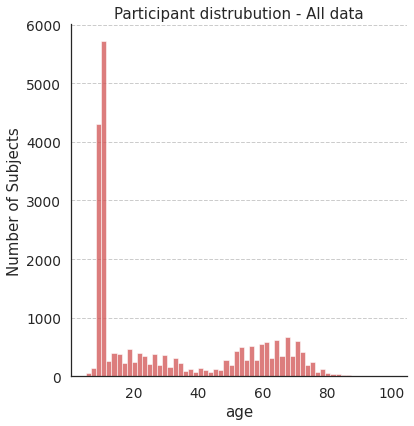

In [120]:
#sns.set(font_scale=1.5, style='whitegrid')
#fig, ax =plt.subplots(1,2)
sns.set(font_scale=1.25, style='white')
sns.displot(df, x="age",  multiple="stack", kde=False, height=6, aspect=10/10,bins=60, color="#D15252")
plt.ylabel('Age')
plt.ylabel('Number of Subjects')
plt.title('Participant distrubution - All data',fontsize=15)
plt.grid(axis='y', linestyle='--')
plt.savefig(os.path.join(fig_dir, 'age_freq.png'),  bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


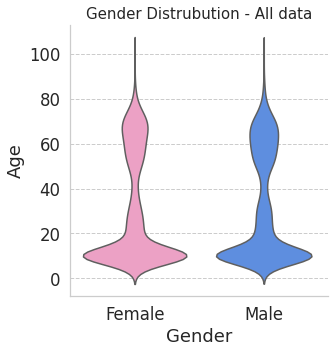

In [121]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set(font_scale=1.5, style='whitegrid')
df.gender = df[['age','sex']]
df.gender['sex'][df.gender['sex'] == 1.0] = 'Female'
df.gender['sex'][df.gender['sex'] == 0.0] = 'Male'
df.gender
sns.set_palette(sns.color_palette(["#F895C5","#4988F4"]))
sns.catplot(x="sex", y="age", kind="violin", inner=None, data=df.gender)
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Gender Distrubution - All data',fontsize=15)
plt.grid(axis='y', linestyle='--')
plt.savefig(os.path.join(fig_dir, 'gender_distrubution.png'),  bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


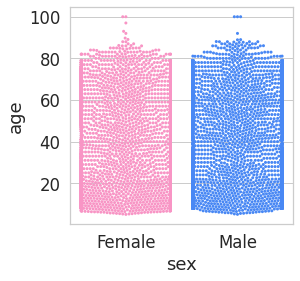

In [ ]:
#sns.swarmplot(x="sex", y="age", color="k", size=3, data=df)
sns.set(rc={'figure.figsize':(4,4)})
sns.set(font_scale=1.5, style='whitegrid')
sns.set_palette(sns.color_palette(["#F895C5","#4988F4"]))
sns.swarmplot(x="sex", y="age", size=3, data=df.gender)
plt.savefig(os.path.join(fig_dir, 'gender_swarm.png'),  bbox_inches='tight')

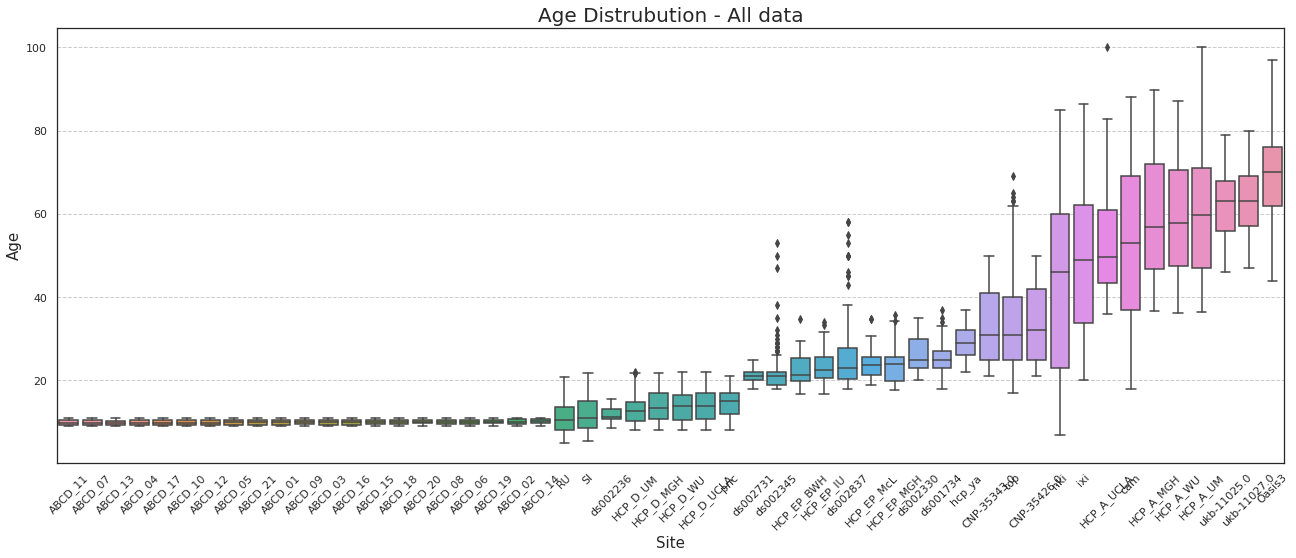

In [122]:
ranks = df.groupby("site")["age"].median().fillna(0).sort_values(ascending=False)[::-1].index
sns.set(font_scale=1.25)
sns.set(rc={'figure.figsize':(22,8)})
sns.set_theme(style='white')
ax = sns.boxplot(x="site", y="age", data=df, order = ranks)
plt.xticks(rotation = 45)
plt.xlabel("Site",fontsize=15)
plt.ylabel("Age",fontsize=15)
plt.title('Age Distrubution - All data',fontsize=20)
#plt.grid(True)
plt.grid(axis='y', linestyle='--')
plt.savefig(os.path.join(fig_dir, 'age_distrubution.png'),  bbox_inches='tight')
plt.show()
plt.close()

# Step 4: organizing directory for each ROI and choose ROI of interest and and dropNA

Choose the ROI of interest

In [123]:
#%%capture
# Colab
doc_path = '/content/drive/MyDrive/wBLR-neuroPCN/data/ROIs'

#Jupyter
#os.chdir(wBLR_dir)
#doc_path = './data/roi/'

In [85]:
# load the idps to process
with open(os.path.join(doc_path,'phenotypes_lh.txt')) as f:
    idp_ids_lh = f.read().splitlines()
with open(os.path.join(doc_path,'phenotypes_rh.txt')) as f:
    idp_ids_rh = f.read().splitlines()
with open(os.path.join(doc_path,'phenotypes_sc.txt')) as f:
    idp_ids_sc = f.read().splitlines()

# we choose here to process all idps
ROI_idp = idp_ids_lh + idp_ids_rh + idp_ids_sc
#print('total ROI:', len(ROI_id))
#print('print top 10 ROI:', ROI_id[1:10])

In [124]:
# Those columns are not belong to any ROI
df_info = ['participant_id','age','sex','group','lh_euler','rh_euler','avg_en','site']
# Choose only those belong to ROI
ROI_id = df.drop(df_info, axis=1).columns
print('total ROI:', len(ROI_id))

total ROI: 217


In [125]:
# Check whether is there any NaN in the data:
if df.isnull().values.any():
    print('there is NaN in the datasets:', df.isnull().sum().sum()) # Count total NaN in the if any: 
    # Remove any subjects that have NaN variables in any of the columns
    df.dropna(subset=ROI_id, inplace=True)
else:
    print('No NaN in the datasets')

No NaN in the datasets


There are some columns contain 0 value:

In [126]:
print('Number of ROI:', len(ROI_id))
# There are some columns contain only zero values:
roi_zero = round(df.loc[:,ROI_id].mean(numeric_only=True, axis = 0),2) == 0
roi_zero = ROI_id[roi_zero].to_list()
print('Columns with zero value:', roi_zero)
# Remove those columns from data frame
print('Before dropping:', df.shape)
df = df.drop(roi_zero, axis=1)
print('After dropping:', df.shape)
# New ROI_id
ROI_id = df.drop(df_info, axis=1).columns
print('Number of ROI remains:', len(ROI_id))

Number of ROI: 217
Columns with zero value: ['Left-WM-hypointensities', 'Right-WM-hypointensities', 'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities']
Before dropping: (23411, 225)
After dropping: (23411, 221)
Number of ROI remains: 213


Set dummy for sites: Dummy can be set manually, or using `create_design_matrix`. For CamCAN analysis, no need for setting dummny code for site

# Step 5: Train/test split

Only split the PNC dataset into:
- 20% include in training dataset (with other sites)
- 80% inculde only phs in testing dataset

In [127]:
# PNC datasets
phs_df= df[df['site'] == 'pnc']
df_tr_phs, df_te_phs = train_test_split(phs_df,
                                #stratify=df['pnc'], 
                                test_size=0.80,
                                random_state=61)
print("Training PhS size is: ", df_tr_phs.shape)
print("Testing PhS size is: ", df_te_phs.shape)

phs_id = df_te_phs[['participant_id','age','sex']]
#phs_id.to_csv(os.path.join(wBLR_dir,'phs_id.csv'))

# Reset index
df_tr_phs.reset_index(drop=True, inplace=True)
df_te_phs.reset_index(drop=True, inplace=True)

# Remaing big datasets
# Remove pnc from big QC
df_rm = df[df['site'] != 'pnc']
df_tr_rm, df_te_rm = train_test_split(df_rm,
                                #stratify=df['pnc'], 
                                test_size=0.10,
                                random_state=64)
print("Training df_tr_rm size is: ", df_tr_rm.shape)
print("Testing df_tr_rm size is: ", df_te_rm.shape)

# Reset index
df_tr_rm.reset_index(drop=True, inplace=True)
df_te_rm.reset_index(drop=True, inplace=True)

# Remove all the testing phs dataset in the big qc dataset
#df_tr = df.drop(df_te.index, axis=0)
#print("Training bigQC size is: ", df_tr.shape)


# Concat final training and testing dataset:
df_tr = pd.concat([df_tr_phs, df_tr_rm])
df_te = pd.concat([df_te_phs, df_te_rm])
df_tr.reset_index(drop=True, inplace=True)
df_te.reset_index(drop=True, inplace=True)

# Save files
#np.savetxt(os.path.join(proc_dir, 'df_tr_phs.txt'), df_tr_phs.values, fmt='%d')
#np.savetxt(os.path.join(proc_dir, 'df_te_phs.txt'), df_te_phs.values, fmt='%d')
#np.savetxt(os.path.join(proc_dir, 'df_tr_rm.txt'), df_tr_rm.values, fmt='%d')
#np.savetxt(os.path.join(proc_dir, 'df_te_rm.txt'), df_te_rm.values, fmt='%d')

df_tr_phs.to_csv(os.path.join(proc_dir, 'df_tr_phs.txt'), index=None)
df_te_phs.to_csv(os.path.join(proc_dir, 'df_te_phs.txt'),index=None)
df_tr_rm.to_csv(os.path.join(proc_dir, 'df_tr_rm.txt'), index=None)
df_te_rm.to_csv(os.path.join(proc_dir, 'df_te_rm.txt'), index=None)
df_tr.to_csv(os.path.join(proc_dir, 'df_tr.txt'), index=None)
df_te.to_csv(os.path.join(proc_dir, 'df_te.txt'), index=None)

df_te[df_te['site']=='pnc']
print('Final training datasets:', df_tr.shape)
print('Final testing datasets:', df_te.shape)

Training PhS size is:  (252, 221)
Testing PhS size is:  (1010, 221)
Training df_tr_rm size is:  (19934, 221)
Testing df_tr_rm size is:  (2215, 221)
Final training datasets: (20186, 221)
Final testing datasets: (3225, 221)


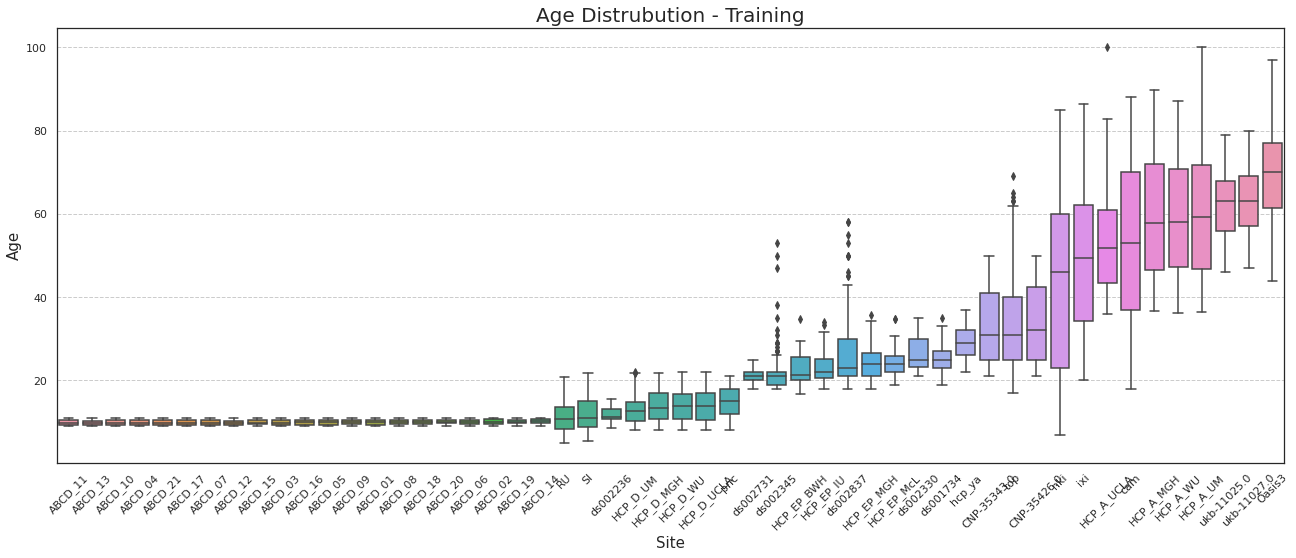

In [128]:
ranks = df_tr.groupby("site")["age"].median().fillna(0).sort_values(ascending=False)[::-1].index
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(22,8)})
sns.set_theme(style='white')
ax = sns.boxplot(x="site", y="age", data=df_tr, order = ranks)
plt.xticks(rotation = 45)
plt.xlabel("Site",fontsize=15)
plt.ylabel("Age",fontsize=15)
plt.title('Age Distrubution - Training',fontsize=20)
#plt.grid(True)
plt.grid(axis='y', linestyle='--')
plt.savefig(os.path.join(fig_dir, 'age_distrubution_training.png'),  bbox_inches='tight')
plt.show()
plt.close()

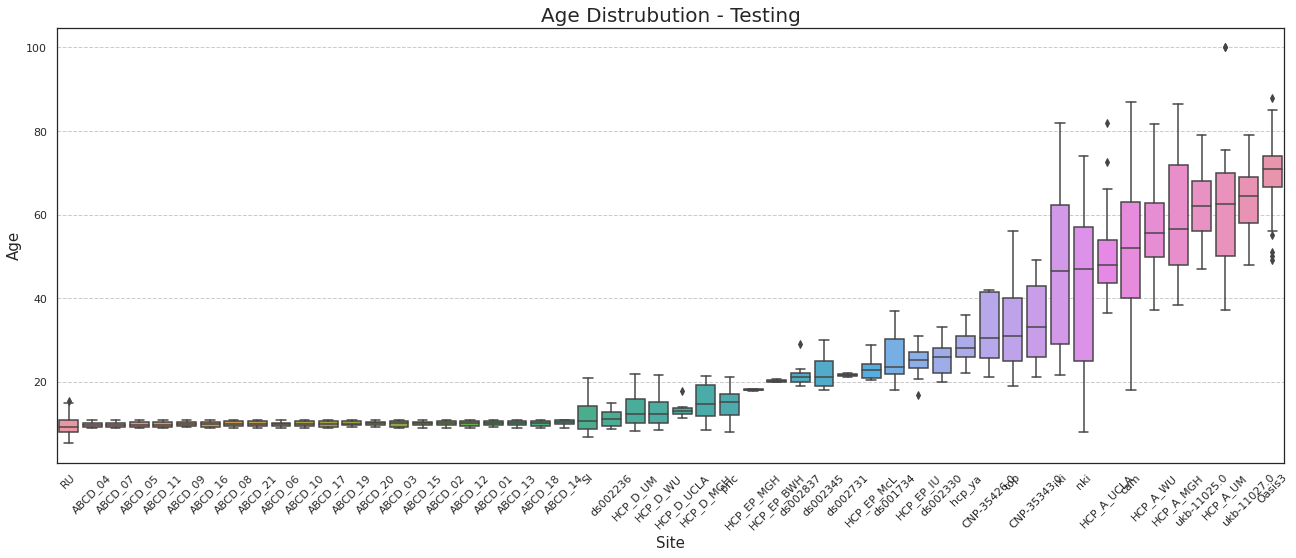

In [129]:
ranks = df_te.groupby("site")["age"].median().fillna(0).sort_values(ascending=False)[::-1].index
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(22,8)})
sns.set_theme(style='white')
ax = sns.boxplot(x="site", y="age", data=df_te, order = ranks)
plt.xticks(rotation = 45)
plt.xlabel("Site",fontsize=15)
plt.ylabel("Age",fontsize=15)
plt.title('Age Distrubution - Testing',fontsize=20)
plt.grid(axis='y', linestyle='--')
plt.savefig(os.path.join(fig_dir, 'age_distrubution_testing.png'),  bbox_inches='tight')
plt.show()
plt.close()

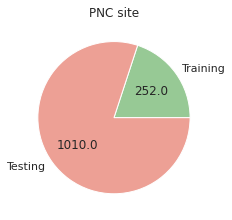

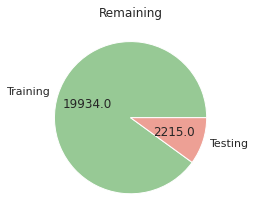

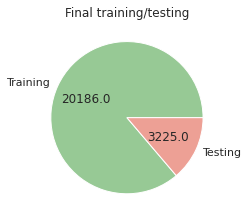

In [130]:
def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return a

plt.figure(figsize=(3.5,3.5))
labels = ["Training", "Testing"]
sizes = np.array([df_tr_phs.shape[0], df_te_phs.shape[0]])
colors = ['#97C995', '#EDA095']

plt.pie(sizes, labels=labels, colors=colors,
        autopct=absolute_value, shadow=False)
plt.title('PNC site')
plt.savefig(os.path.join(fig_dir, 'train_test PNC site.png'),  bbox_inches='tight')
plt.show()

plt.figure(figsize=(3.5,3.5))
labels = ["Training", "Testing"]
sizes = np.array([df_tr_rm.shape[0], df_te_rm.shape[0]])


plt.pie(sizes, labels=labels, colors=colors,
        autopct=absolute_value, shadow=False)
plt.title('Remaining')
plt.savefig(os.path.join(fig_dir, 'train_test Remaining sites.png'),  bbox_inches='tight')
plt.show()

plt.figure(figsize=(3.5,3.5))
labels = ["Training", "Testing"]
sizes = np.array([df_tr.shape[0], df_te.shape[0]])

plt.pie(sizes, labels=labels, colors=colors,
        autopct=absolute_value, shadow=False)
plt.title('Final training/testing')
plt.savefig(os.path.join(fig_dir, 'train_test all sites.png'),  bbox_inches='tight')
plt.show()

Describe datasets after spliting

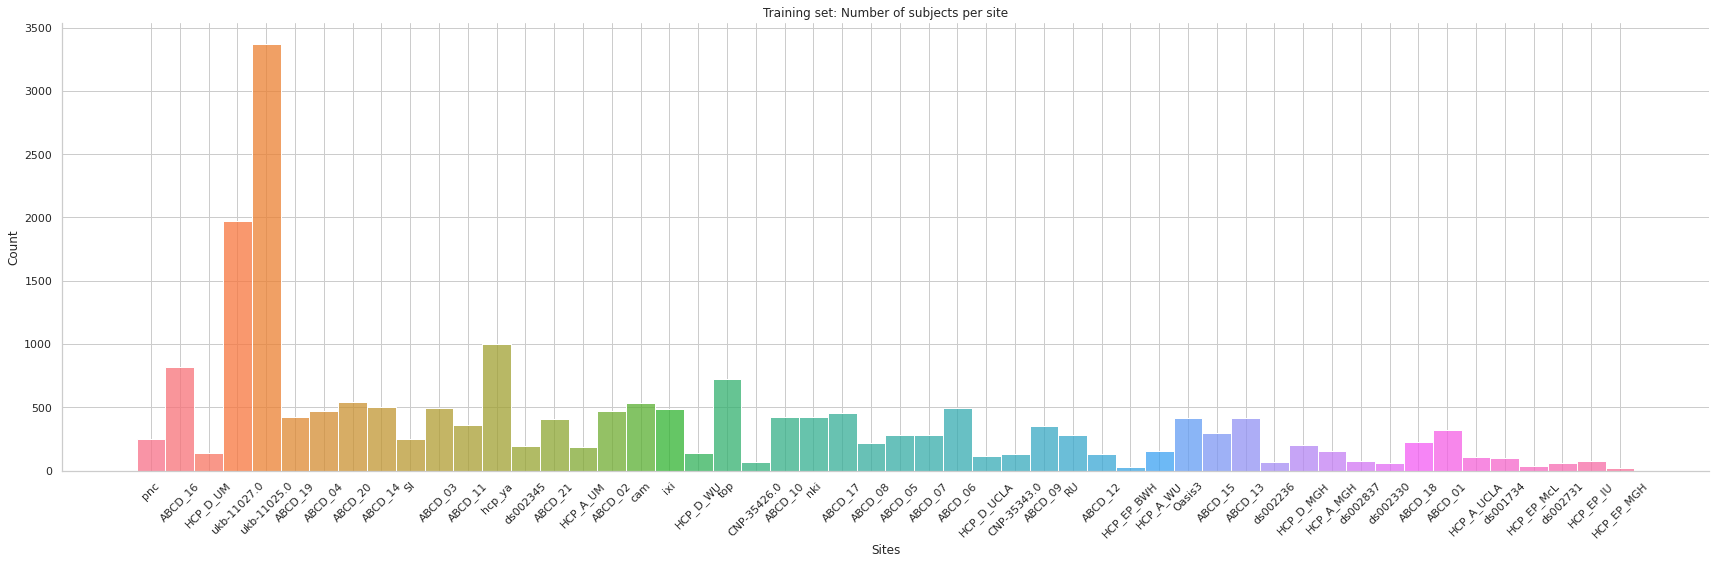

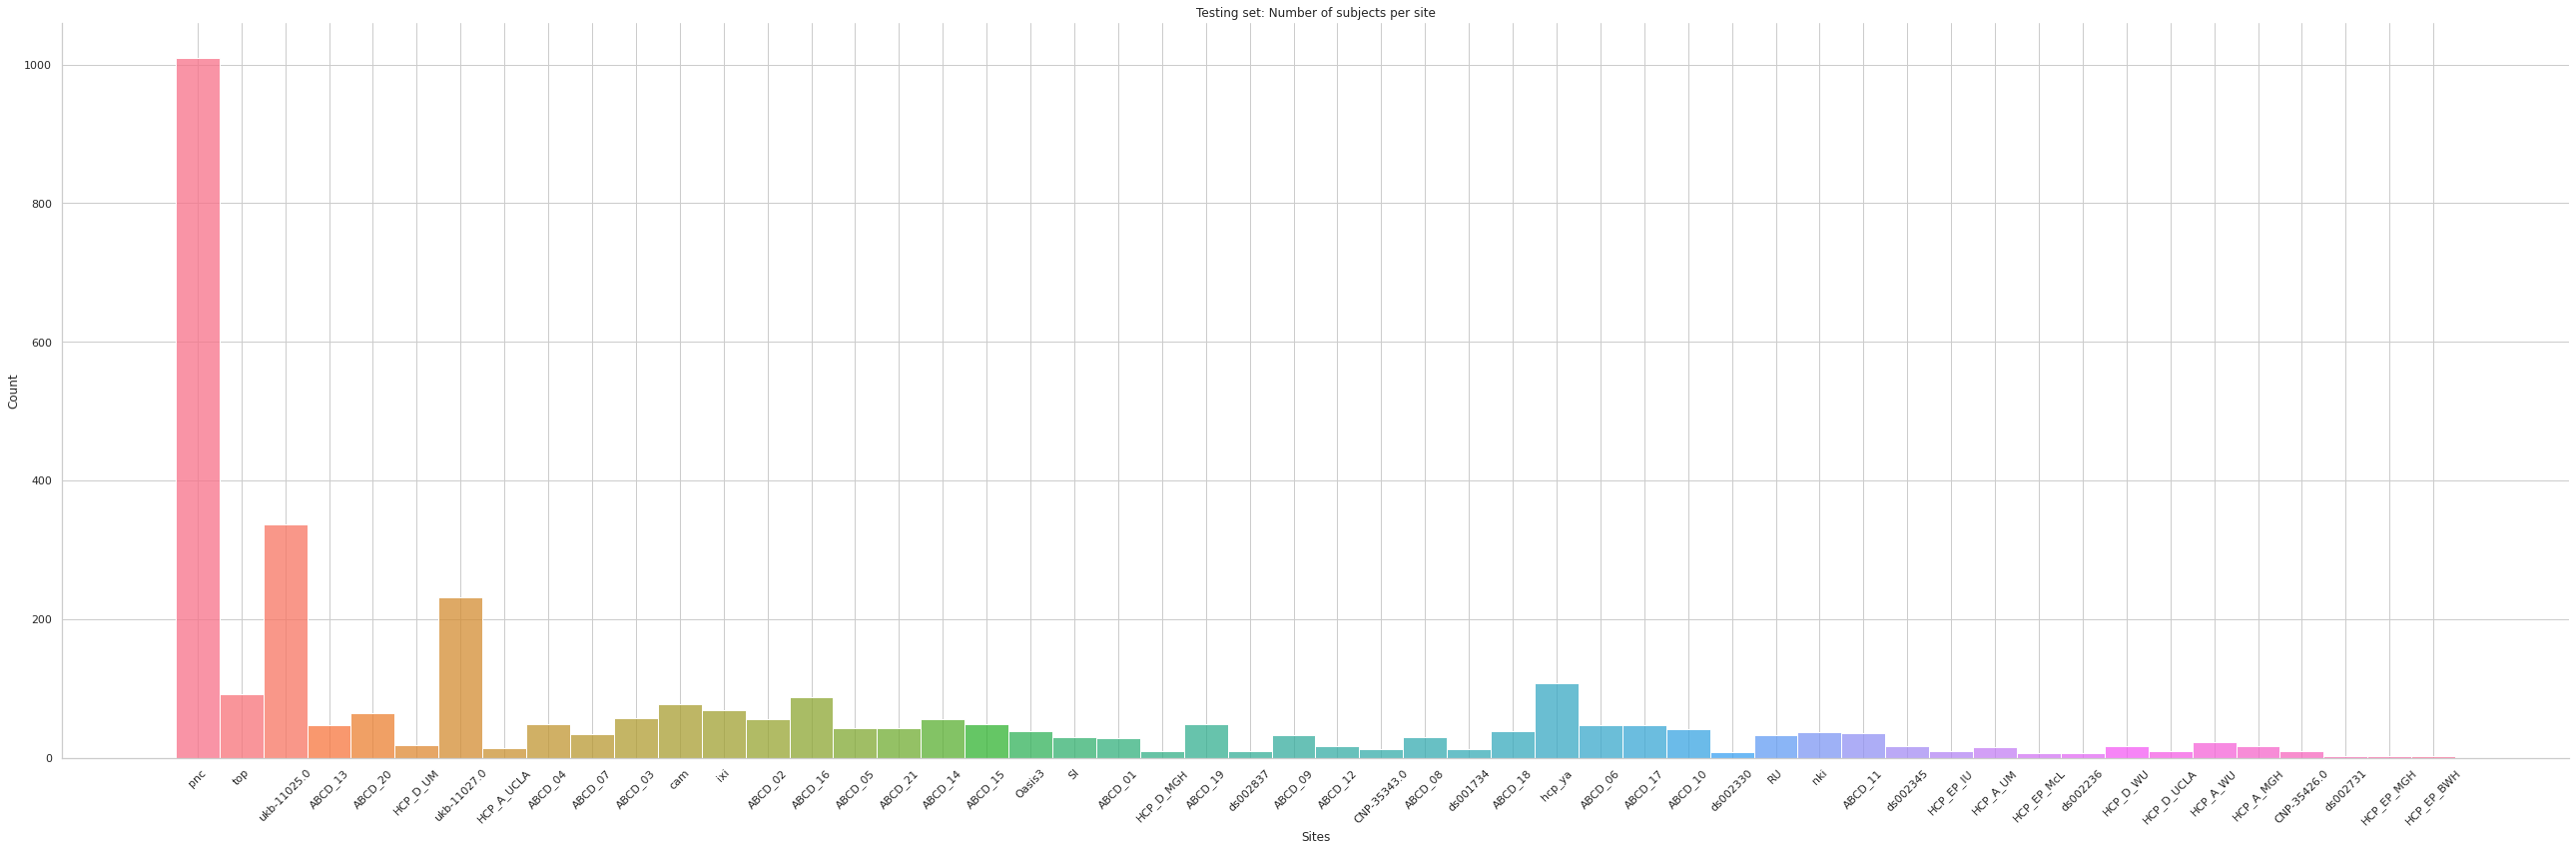

In [131]:
sns.set_theme(style="whitegrid")
ax = sns.displot(df_tr, x="site",  multiple="stack", kde=False, 
            hue='site',
            height=8, 
            aspect=24/8,
            bins=2,
            legend = None)
plt.title('Training set: Number of subjects per site')
plt.xlabel('Sites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.set_theme(style="whitegrid")
ax = sns.displot(df_te, x="site",  multiple="stack", kde=False, 
            hue='site',
            height=12, 
            aspect=24/8,
            bins=5,
            legend = None)
plt.title('Testing set: Number of subjects per site')
plt.xlabel('Sites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [132]:
df1 = pd.DataFrame(df_tr['site'].value_counts())
df2 = pd.DataFrame(df_te['site'].value_counts())
site_df = pd.merge(df1, df2, left_index=True, right_index=True)
#df. rename(columns = {'old_col1':'new_col1', 'old_col2':'new_col2'}
site_df.rename(columns={"site_x": "training", "site_y": "testing"}, inplace = True)
site_df['site'] = site_df.index
site_df

,training,testing,site
ukb-11025.0,3371,336,ukb-11025.0
ukb-11027.0,1972,232,ukb-11027.0
hcp_ya,1004,108,hcp_ya
ABCD_16,817,87,ABCD_16
top,720,92,top
ABCD_20,545,64,ABCD_20
cam,535,77,cam
ABCD_14,506,55,ABCD_14
ABCD_06,496,47,ABCD_06
ABCD_03,492,57,ABCD_03


In [133]:
pd.DataFrame(df_tr['site'].value_counts())

,site
ukb-11025.0,3371
ukb-11027.0,1972
hcp_ya,1004
ABCD_16,817
top,720
ABCD_20,545
cam,535
ABCD_14,506
ABCD_06,496
ABCD_03,492


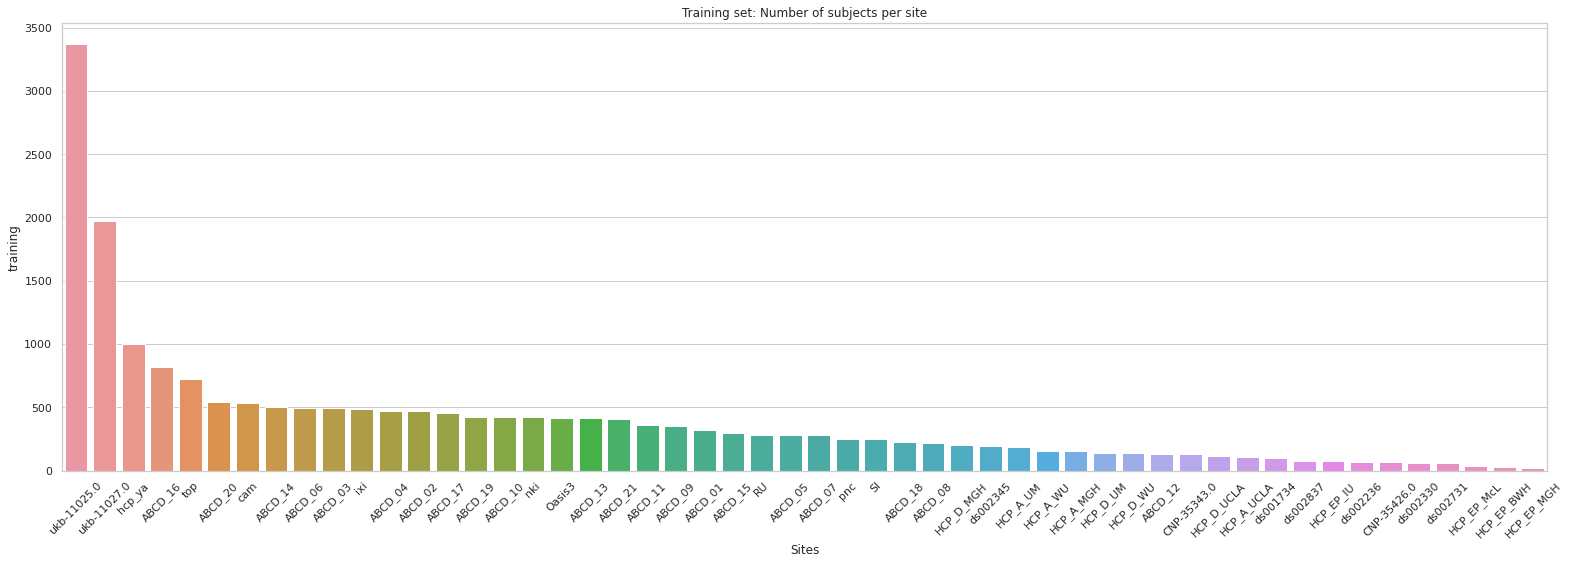

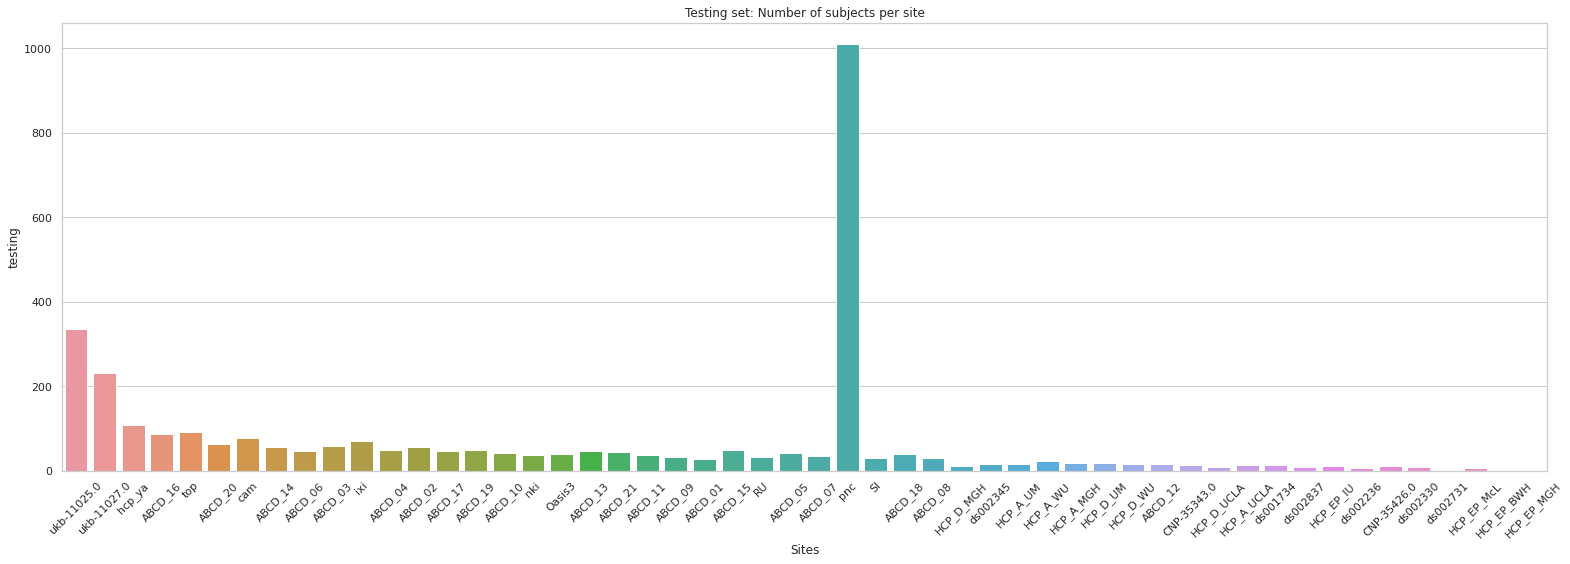

In [134]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'site',
                 y = 'training',
                 #height=8, 
                 #aspect=24/8,
                 data = site_df)
plt.title('Training set: Number of subjects per site')
plt.xlabel('Sites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'site',
                 y = 'testing',
                 #height=8, 
                 #aspect=24/8,
                 data = site_df)
plt.title('Testing set: Number of subjects per site')
plt.xlabel('Sites')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Jump to step 7.5

# Step 6:  Generate resp_file and cov_bspline_file for each ROI

Set out put directory:

Choose covariate and threshold:

In [135]:
# Absolute Z threshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# Choose covariates:
cols_cov = ['age','sex']

# Choose threshold for age:
xmin = round(min(df['age']) - 2,1)
xmax = round(max(df['age']) + 2,1)
print('min age:', xmin)
print('max age:', xmax)

min age: 3.0
max age: 102.0


Run loop for generating directories and files for each ROI:

In [136]:
%%capture
#%%script false --no-raise-error
roi_error = []
for roi_num, roi in enumerate(ROI_id): 
    print('Running ROI:', roi_num, roi)
    roi_dir = os.path.join(model_dir,roi)
    os.makedirs(roi_dir, exist_ok = True)
    os.chdir(roi_dir)
    
    
    # Extract the response variables for training and test set
    y_tr = df_tr[roi].to_numpy() 
    y_te = df_te[roi].to_numpy()
    
    # On checking
    # remove gross outliers and implausible values
    yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    #yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
    #nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
    y_tr = y_tr[nz_tr]
    #y_te = y_te[nz_te]
    
    ###
    #resp_file_tr = os.path.join(roi_dir, 'resp_tr.txt')
    #resp_file_te = os.path.join(roi_dir, 'resp_te.txt') 
    #np.savetxt(resp_file_tr, y_tr)
    #np.savetxt(resp_file_te, y_te)
    ###
    # There are some ROIs that are not in the same dimension after this step,
    # then keep only those ROI retain same dimension:
    if len(y_tr) == df_tr.shape[0] and len(y_te) == df_te.shape[0]:
        # write out the response variables for training and test
        resp_file_tr = os.path.join(roi_dir, 'resp_tr.txt')
        resp_file_te = os.path.join(roi_dir, 'resp_te.txt') 
        np.savetxt(resp_file_tr, y_tr)
        np.savetxt(resp_file_te, y_te)
    else:
        roi_error.append(roi)
 

    # Configure and save the design matrix
    # Create design matrix for training:
    X_tr = create_design_matrix(df_tr[cols_cov],
                                site_ids = df_tr['site'],
                                all_sites = site_ids_tr, 
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax) 
    cov_file_tr = os.path.join(roi_dir, 'cov_bspline_tr.txt') 
    np.savetxt(cov_file_tr, X_tr)

    # Create design matrix for testing:
    X_te = create_design_matrix(df_te[cols_cov],  
                                site_ids = df_te['site'], 
                                all_sites = site_ids_tr, 
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax) 
    cov_file_te = os.path.join(roi_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_te, X_te)

Checking the covariance matrix. 
- First row: intercept
- Second row: age
- Third row: gender
- Last 7 rows: b- spline

There are some ROI that do not return response file with the same dimension of original matrix. This may be due that those ROI contain noise signals that they did not pass the QC threshold. Those files are needed to be removed.

In [110]:
%%script false --no-raise-error
# ROI which does not passed:
print('number of ROI that not pass:', len(roi_error))
print(roi_error)
# remove from ROI_id(
print('total ROI run:', len(ROI_id))
ROI_id = [roi for roi in ROI_id if roi not in roi_error]
print('total ROI after remove bad ROI:', len(ROI_id))
ROI_id_error = ROI_id
print('bad ROI:', len(ROI_id_error))

In [113]:
# Create listing of ROI run:
os.chdir(proc_dir)
with open('roi_list.txt', 'w') as f:
    for item in ROI_id:
        f.write("%s\n" % item)
len(ROI_id)

5

# Step 7: Algorithm & Modeling for Normative Modeling

Note: Step 7 have already been processed on HPC cluster:

Estimate the normative modeling for each ROI.

In [102]:
%%capture
#%%script false --no-raise-error
# Loop through ROIs

#  Warping function to use? We can set this to None in order to fit a vanilla Gaussian noise model
warp =  'WarpSinArcsinh' #'WarpSinArcsinh'

# Original
for roi in ROI_id:
    print('Running ROI:', roi)
    roi_dir = os.path.join(model_dir,roi)
    os.chdir(roi_dir)
       
    # Load Cov 
    cov_file_tr = os.path.join(roi_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(roi_dir, 'cov_bspline_te.txt')
    # Load response files
    resp_file_tr = os.path.join(roi_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(roi_dir, 'resp_te.txt')
    
#    if not force_refit and os.path.exists(os.path.join(roi_dir, 'Models', 'NM_0_0_estimate.pkl')):
#        print('Making predictions using a pre-existing model...')
#        suffix = 'predict'
#        # Make prdictsion with test data
#        predict(cov_file_te, 
#                alg='blr', 
#                respfile=resp_file_te, 
#                model_path=os.path.join(idp_dir,'Models'),
#                outputsuffix=suffix)
#        
#    else:  
    # run a basic model
    print('Estimating the normative model...')
    estimate(cov_file_tr,
             resp_file_tr,
             testresp=resp_file_te,
             testcov=cov_file_te,
             alg = 'blr',
             optimizer = 'l-bfgs-b',
             savemodel = True,
             warp = warp,
             warp_reparam=True
                  )
    print('END ---------------------------------------------------')

OSError: ignored

In [45]:
%%script false --no-raise-error
print(roi_dir)
cov_file_tr = load_2d(os.path.join(roi_dir, 'cov_bspline_tr.txt'))
cov_file_te = load_2d(os.path.join(roi_dir, 'cov_bspline_te.txt'))
# Load response files
resp_file_tr = load_2d(os.path.join(roi_dir, 'resp_tr.txt'))
resp_file_te = load_2d(os.path.join(roi_dir, 'resp_te.txt'))

Check number of Z files

In [112]:
#%%capture
# Check number of ROI contain Z-files
from pathlib import Path
nm_roi = []
for roi in os.listdir(model_dir):
  #print('Running ROI', roi_num, roi)
  roi_dir = os.path.join(model_dir, roi)
  os.chdir(roi_dir) # Move to current IDP dir
  filename = roi_dir + '/Z_estimate.txt'
  path_check = Path(filename)
  if path_check.is_file():
    nm_roi.append(roi)
  else:
    print(f'The file {roi} does not exist')

# Number of ROI contain z files:
ROI_id = nm_roi
len(ROI_id)

The file MaskVol-to-eTIV does not exist
The file lh_S_oc_middle&Lunatus_thickness does not exist
The file rh_S_collat_transv_post_thickness does not exist
The file rh_S_suborbital_thickness does not exist
The file lh_S_interm_prim-Jensen_thickness does not exist
The file lh_S_oc-temp_med&Lingual_thickness does not exist
The file rh_G_parietal_sup_thickness does not exist
The file lh_S_temporal_transverse_thickness does not exist
The file rh_Lat_Fis-ant-Vertical_thickness does not exist
The file rh_S_oc_middle&Lunatus_thickness does not exist
The file rh_S_interm_prim-Jensen_thickness does not exist
The file rh_G_front_inf-Opercular_thickness does not exist
The file lh_G_Ins_lg&S_cent_ins_thickness does not exist
The file Left-Cerebellum-White-Matter does not exist
The file BrainSegVol does not exist
The file lh_Pole_occipital_thickness does not exist
The file rh_G_temp_sup-Lateral_thickness does not exist
The file rh_G_subcallosal_thickness does not exist
The file lh_G_insular_short_th

5

# Step 8: Create dummy code for gender for submitting to cluster/plot Z

In [47]:
os.chdir(model_dir)

# 0 = male 1 = female

#FEMALES
sex = 1 # 0 = male 1 = female
if sex == 0: 
    clr = 'blue'
    gender = 'male'
else:
    clr = 'red'
    gender = 'female'
# create dummy data for visualisation: 
print('configuring dummy data ...')
age_range = np.arange(xmin, xmax, 0.5) 
X0_dummy = np.zeros((len(age_range), 2)) 
X0_dummy[:,0] = age_range 
X0_dummy[:,1] = sex 

# create the dummy design matrix 
X_dummy = create_design_matrix(X0_dummy, 
                               xmin=xmin, 
                               xmax=xmax, 
                               site_ids=None, 
                               all_sites=site_ids_tr
                               )

# save the dummy covariates
cov_file_dummy = os.path.join(proc_dir,'cov_bspline_' + gender + '_dummy.txt')
np.savetxt(cov_file_dummy, X_dummy)


#MALES
sex = 0 # 0 = male 1 = female
if sex == 0: 
    clr = 'blue'
    gender = 'male'
else:
    clr = 'red'
    gender = 'female'
# create dummy data for visualisation: 
print('configuring dummy data ...')
age_range = np.arange(xmin, xmax, 0.5) 
X0_dummy = np.zeros((len(age_range), 2)) 
X0_dummy[:,0] = age_range 
X0_dummy[:,1] = sex 

# create the dummy design matrix 
X_dummy = create_design_matrix(X0_dummy, 
                               xmin=xmin, 
                               xmax=xmax, 
                               site_ids=None, 
                               all_sites=site_ids_tr
                               )

# save the dummy covariates
cov_file_dummy = os.path.join(proc_dir,'cov_bspline_' + gender + '_dummy.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...
configuring dummy data ...


# Step 9: Plot the Z-score for some ROI

In [ ]:
# Choose some region of interest or all: ROI_id
#ROI_ids = ['TotalGrayVol','CerebralWhiteMatterVol']
#ROI_idp: #All ROI
#ROI_ids: #ROI of interest
#ROI_random = random.sample(ROI_id.tolist(), 20) 

In [ ]:
# Writing plot function
def roi_plot(ROI_id, sites, image, cen25 = 0.35, cen05 = 0.25, cen01 = 0.15, size=20, alpha = 0.4):  

  if sex == 0: 
      clr = 'blue'
      clr1 = '#4988F4'
      gender = 'male'
  else:
      clr = 'red'
      clr1 = '#F895C5'
      gender = 'female'
  # Read save dummmy files
  cov_file_dummy = os.path.join(proc_dir,'cov_bspline_' + gender + '_dummy.txt')
  X_dummy = np.loadtxt(cov_file_dummy)


  for roi_num, roi in enumerate(ROI_id): #ROI of interest
  #for roi_num, roi in enumerate(random.sample(ROI_id.tolist(), 20)): 
      print('Running ROI', roi_num, roi, ':')
      roi_dir = os.path.join(model_dir, roi)
      os.chdir(roi_dir) # Move to current IDP dir

      # Load predictive and  response variables generated by NM
      yhat_te = load_2d(os.path.join(roi_dir, 'yhat_estimate.txt'))
      s2_te = load_2d(os.path.join(roi_dir, 'ys2_estimate.txt'))
      y_te = load_2d(os.path.join(roi_dir, 'resp_te.txt'))
              
      ### set up the covariates for the dummy data 
      print('Making predictions with dummy covariates (for visualisation)')
      yhat, s2 = predict(cov_file_dummy, 
                          alg = 'blr', 
                          respfile = None,
                          model_path = os.path.join(roi_dir,'Models'), 
                          outputsuffix = '_dummy')

      # load the normative model
      with open(os.path.join(roi_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
          nm = pickle.load(handle)
          
      # get the warp and warp parameters
      W = nm.blr.warp 
      warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
      
                
      ### MAKING WARP FUNCTIONS

      med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0] 
      med_te = med_te[:, np.newaxis]
      print('metrics:', evaluate(y_te, med_te))
          
      # then, we warp dummy predictions to create the plots
      # med: median
      # pr_int: predictive interval
      med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

      # extract the different variance components to visualise
      beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
      s2n = 1/beta # aleatoric uncertainty: computing the uncertainty on the variation of input data
      s2s = s2-s2n # epistemic uncertainty: uncertainty of the model itself

      #NOTE:
      X_te = load_2d(os.path.join(roi_dir, 'cov_bspline_te.txt'))

      ### Setting value to plot the data points
      #y_te_rescaled_all = np.zeros_like(y_te) 
      #idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[:,1].min(), X_dummy[:,1] < X_te[:,1].max())
      #y_te_rescaled = y_te - np.median(y_te) + np.median(med[idx_dummy])
      ####
      y_te_rescaled = np.zeros_like(y_te)
      for sid, site in enumerate(site_ids_tr):
        #first, we select the data points belonging to this particular site:
        idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
        if len(idx) == 0:
          print('No gender for this site', sid, site, 'skipping...')
          continue
        #then directly adjust the data
        idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
        y_te_rescaled[idx] = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])


      # plot the median of the dummy data
      plt.plot(age_range, med, clr)

      # fill the gaps in between the centiles
      # computing 25,95, 99 centiles using warp prediction:
      junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
      junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
      junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
      # Plot
      plt.fill_between(age_range, pr_int25[:,0], pr_int25[:,1], alpha = cen25,color=clr1)
      plt.fill_between(age_range, pr_int95[:,0], pr_int95[:,1], alpha = cen05,color=clr1)
      plt.fill_between(age_range, pr_int99[:,0], pr_int99[:,1], alpha = cen01,color=clr1)
              

      # make the width of each centile proportional to the epistemic uncertainty:
      junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
      junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
      junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
      junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
      junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
      junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
      plt.fill_between(age_range, pr_int25l[:,0], pr_int25u[:,0], alpha = cen25,color=clr1)
      plt.fill_between(age_range, pr_int95l[:,0], pr_int95u[:,0], alpha = cen05,color=clr1)
      plt.fill_between(age_range, pr_int99l[:,0], pr_int99u[:,0], alpha = cen01,color=clr1)
      plt.fill_between(age_range, pr_int25l[:,1], pr_int25u[:,1], alpha = cen25,color=clr1)
      plt.fill_between(age_range, pr_int95l[:,1], pr_int95u[:,1], alpha = cen05,color=clr1)
      plt.fill_between(age_range, pr_int99l[:,1], pr_int99u[:,1], alpha = cen01,color=clr1)

      # plot actual centile lines
      plt.plot(age_range, pr_int25[:,0],color=clr1, linewidth=0.3)
      plt.plot(age_range, pr_int25[:,1],color=clr1, linewidth=0.3)
      plt.plot(age_range, pr_int95[:,0],color=clr1, linewidth=0.3)
      plt.plot(age_range, pr_int95[:,1],color=clr1, linewidth=0.3)
      plt.plot(age_range, pr_int99[:,0],color=clr1, linewidth=0.3)
      plt.plot(age_range, pr_int99[:,1],color=clr1, linewidth=0.3)
    
      if sites is None: 
        print("Running on ALL testing dataset")
        idx_sex = (X_te[:,2] == sex)
        plt.scatter(X_te[idx_sex,1], y_te_rescaled[idx_sex], s=size, color=clr, alpha = alpha)
        
      else:
        print("Running on PhS dataset") 
        idx_sex = (X_te[:df_te_phs.shape[0]][:,2] == sex)
        plt.scatter(X_te[:df_te_phs.shape[0]][idx_sex,1], y_te_rescaled[:df_te_phs.shape[0]][idx_sex], s=size, color=clr, alpha = alpha) # PhS
        plt.xlim((5,25))

      plt.xlabel('Age')
      plt.ylabel(roi) 
      plt.title(roi)
      #plt.yscale("log")
      #plt.ylim(min(y_te_rescaled[idx_sex])*0.9,max(y_te_rescaled[idx_sex])*1.1)
      #ylabel.set_major_formatter(ticker.EngFormatter())
      plt.savefig(os.path.join(image, roi + '_' + str(gender)),  bbox_inches='tight')
      plt.show()

Running ROI 0 TotalGrayVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([57358.61854222]), 'Rho': array([0.76256085]), 'pRho': array([0.]), 'SMSE': array([0.41957658]), 'EXPV': array([0.58084494])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


No gender for this site 22 HCP_EP_MGH skipping...
Running on ALL testing dataset


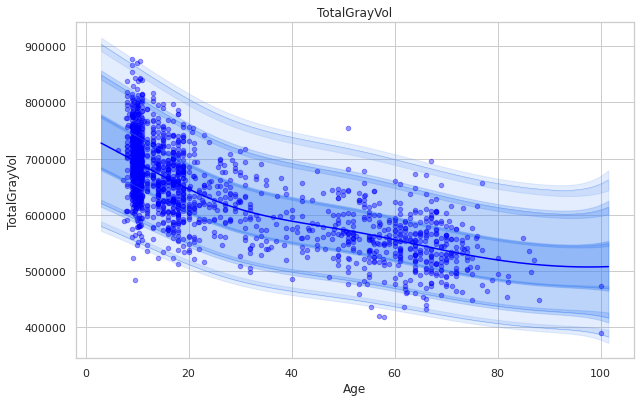

Running ROI 1 CerebralWhiteMatterVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([48566.16706573]), 'Rho': array([0.62175638]), 'pRho': array([0.]), 'SMSE': array([0.61519627]), 'EXPV': array([0.386302])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


No gender for this site 22 HCP_EP_MGH skipping...
Running on ALL testing dataset


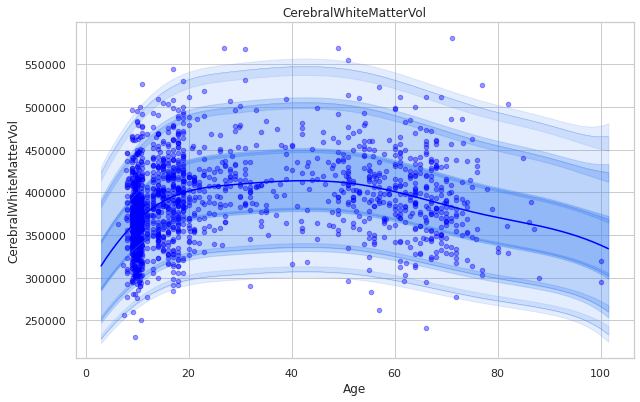

In [ ]:
sns.set(rc={'figure.figsize':(10,6.18)})
sns.set(style='whitegrid')
random.seed(93)

image = os.path.join(image_dir, 'brain_trajectories')
os.makedirs(image, exist_ok = True)


sex = 0 # 0 = male 1 = female
roi_plot(ROI_ids,sites = None, size = 20, alpha = 0.4)

Running ROI 0 TotalGrayVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([57358.61854222]), 'Rho': array([0.76256085]), 'pRho': array([0.]), 'SMSE': array([0.41957658]), 'EXPV': array([0.58084494])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on ALL testing dataset


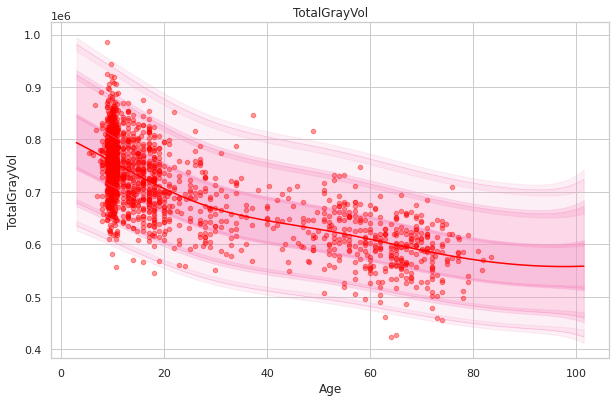

Running ROI 1 CerebralWhiteMatterVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([48566.16706573]), 'Rho': array([0.62175638]), 'pRho': array([0.]), 'SMSE': array([0.61519627]), 'EXPV': array([0.386302])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on ALL testing dataset


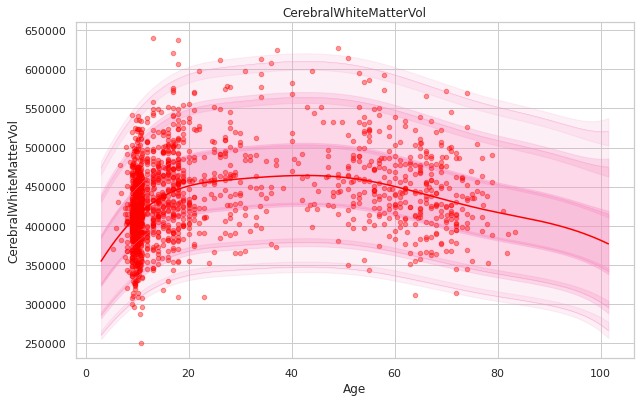

In [ ]:
sex = 1 # 0 = male 1 = female
roi_plot(ROI_ids,sites = None,image, size = 20, alpha = 0.4)

Plot subjects belongs the PNC data

Running ROI 0 TotalGrayVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([57358.61854222]), 'Rho': array([0.76256085]), 'pRho': array([0.]), 'SMSE': array([0.41957658]), 'EXPV': array([0.58084494])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


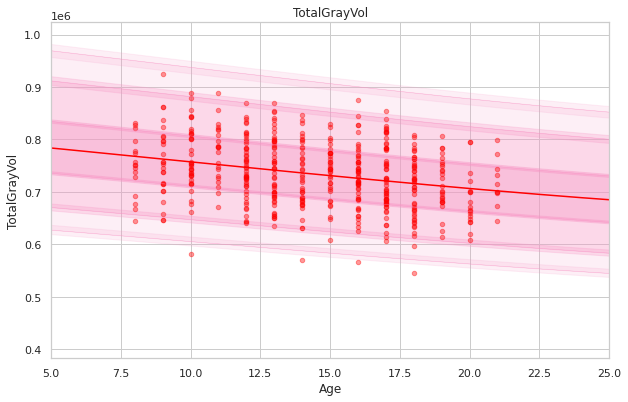

Running ROI 1 CerebralWhiteMatterVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([48566.16706573]), 'Rho': array([0.62175638]), 'pRho': array([0.]), 'SMSE': array([0.61519627]), 'EXPV': array([0.386302])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


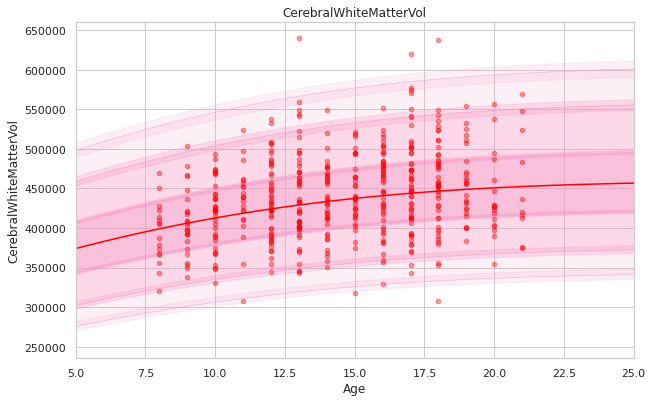

In [ ]:
image = os.path.join(image_dir, 'brain_PNC')
os.makedirs(image, exist_ok = True)
sex = 1 # 0 = male 1 = female
roi_plot(ROI_ids,sites = True, image, size = 20, alpha = 0.4)

Running ROI 0 TotalGrayVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([57358.61854222]), 'Rho': array([0.76256085]), 'pRho': array([0.]), 'SMSE': array([0.41957658]), 'EXPV': array([0.58084494])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


No gender for this site 22 HCP_EP_MGH skipping...
Running on PhS dataset


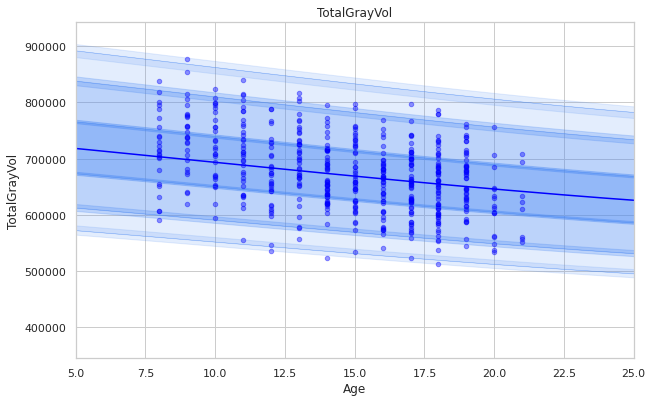

Running ROI 1 CerebralWhiteMatterVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([48566.16706573]), 'Rho': array([0.62175638]), 'pRho': array([0.]), 'SMSE': array([0.61519627]), 'EXPV': array([0.386302])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


No gender for this site 22 HCP_EP_MGH skipping...
Running on PhS dataset


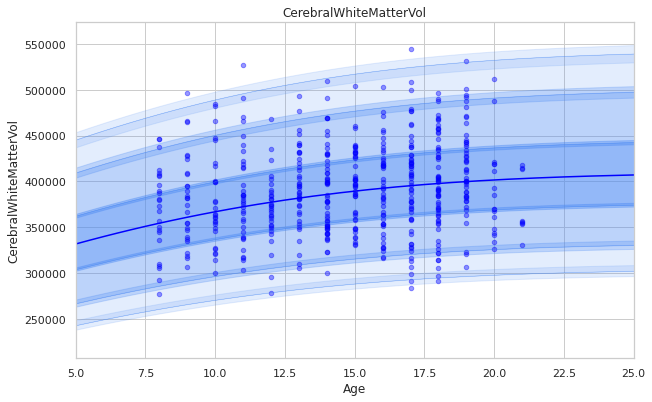

In [ ]:
sex = 0 # 0 = male 1 = female
roi_plot(ROI_ids,sites = True, image, size = 20, alpha = 0.4)

# Step 10 - Compute error metrics and Plot

In this section we compute the following error metrics for all IDPs (all evaluated on the test set):

- Negative log likelihood (NLL)
- Explained variance (EV)
- Mean standardized log loss (MSLL)
- Bayesian information Criteria (BIC)
- Skew and Kurtosis of the Z-distribution

In [ ]:
# initialise dataframe we will use to store quantitative metrics 
warp =  'WarpSinArcsinh' #'WarpSinArcsinh'
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])
suffix = 'estimate'

for roi in ROI_id: 
    roi_dir = os.path.join(model_dir,roi)
    
    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(roi_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(roi_dir, 'ys2_' + suffix + '.txt'))
    y_tr = load_2d(os.path.join(roi_dir, 'resp_tr.txt'))
    y_te = load_2d(os.path.join(roi_dir, 'resp_te.txt'))
    
    # Choose only those belong to phs
    #y_te = y_te[:df_te_phs.shape[0]]
    #yhat_te = yhat_te[:df_te_phs.shape[0]]
    #s2_te = s2_te[:df_te_phs.shape[0]]
    
    
    
    with open(os.path.join(roi_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  
        
        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp
        
        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
       
        # evaluation metrics
        metrics = evaluate(y_te, med_te)
        
        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     
    
    Z = np.loadtxt(os.path.join(roi_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
    
    blr_metrics.loc[len(blr_metrics)] = [roi, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]
    
blr_metrics.to_pickle(os.path.join(proc_dir,'blr_metrics.pkl'))
blr_metrics.to_csv(os.path.join(proc_dir,'blr_metrics.csv'), index_label=False)

In [ ]:
# Load blr metrics
#blr_metrics = pd.read_pickle(os.path.join(proc_dir,'blr_metrics.pkl'))
blr_metrics = pd.read_csv(os.path.join(proc_dir,'blr_metrics.csv'))
display(blr_metrics)

,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
0,lh_G&S_frontomargin_thickness,-6524.508868,0.306800,-0.175740,-13009.366757,0.179387,0.885691
1,lh_G&S_occipital_inf_thickness,-6360.155065,0.288814,-0.193221,-12680.659151,0.018620,0.210075
2,lh_G&S_paracentral_thickness,-4791.860575,0.344408,-0.209021,-9544.070172,0.033813,0.703560
3,lh_G&S_subcentral_thickness,-6495.917696,0.318702,-0.185878,-12952.184413,0.039760,0.174304
4,lh_G&S_transv_frontopol_thickness,-2616.867450,0.357054,-0.195350,-5194.083922,0.243473,0.741994
...,...,...,...,...,...,...,...
208,lhSurfaceHoles,77903.962266,0.566845,-0.562846,155847.541881,-0.444806,2.744026
209,rhSurfaceHoles,77303.436351,0.540059,-0.496963,154646.489650,-0.409894,2.304764
210,SurfaceHoles,89842.825494,0.588372,-0.564810,179725.268537,-0.801759,5.239476
211,EstimatedTotalIntraCranialVol,265043.860711,0.271478,1.965752,530127.338770,-12.575923,168.756940


In [ ]:
print('Before QC, number of ROI:', blr_metrics.shape[0])
#blr_metrics = blr_metrics[blr_metrics['MSLL'] < 0]
blr_metrics_qc = blr_metrics[abs(blr_metrics['Skew']) < 5]
blr_metrics_qc = blr_metrics_qc[blr_metrics_qc['Kurtosis'] < 10]
blr_metrics_qc.to_pickle(os.path.join(proc_dir,'blr_metrics_qc.pkl'))
blr_metrics_qc.to_csv(os.path.join(proc_dir,'blr_metrics_qc.csv'), index_label=False)
print('After QC, , number of ROI:', blr_metrics_qc.shape[0])

# Write out the list of ROI
os.chdir(proc_dir)
with open('roi_blr.txt', 'w') as f:
    for item in blr_metrics['eid'].to_list():
        f.write("%s\n" % item)

Before QC, number of ROI: 213
After QC, , number of ROI: 199


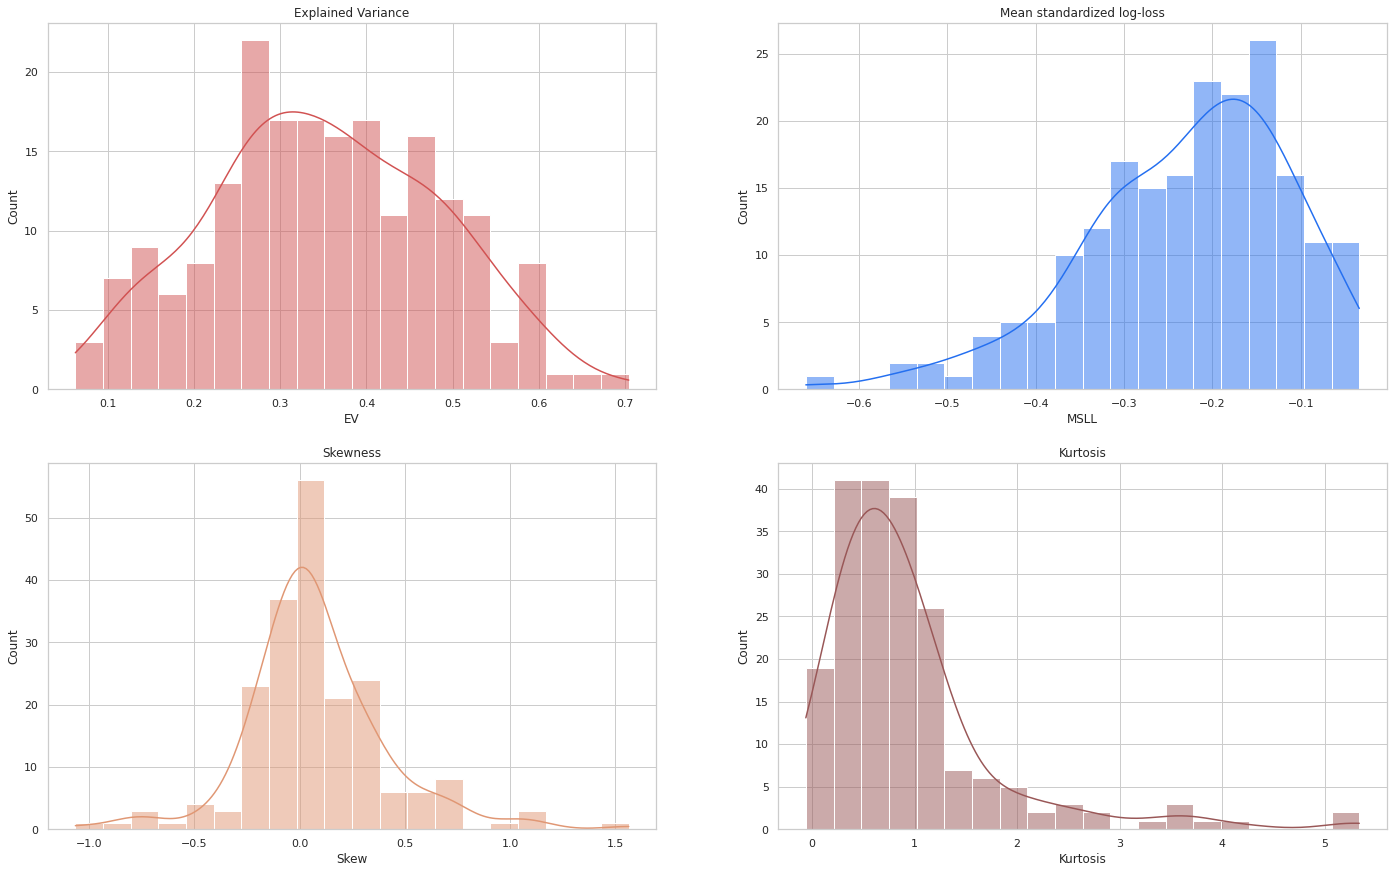

In [ ]:
#blr_metrics = pd.read_pickle(os.path.join(proc_dir,'blr_metrics.pkl'))
#blr_metrics = blr_metrics[blr_metrics['eid'].isin(ROI_idp)]
#blr_metrics_qc = pd.read_pickle(os.path.join(proc_dir,'blr_metrics_qc.pkl'))
blr_metrics_qc = pd.read_csv(os.path.join(proc_dir,'blr_metrics_qc.csv'))
blr_metrics = blr_metrics_qc

# Creating a grid figure with matplotlib
fig, my_grid = plt.subplots(nrows=2, ncols=2, figsize=(24,14.833))
# Histograms
# Plot 1
g1 = sns.histplot(blr_metrics, x="EV", bins = 20, color='#D15252', multiple="stack", kde=True, ax=my_grid[0,0])  # distplot is deprecate and replaced by histplot
g1.set_title('Explained Variance')

# Plot 2
g2 = sns.histplot(blr_metrics, x="MSLL",  bins = 20, color='#246FF0', multiple="stack", kde=True, ax=my_grid[0,1])  # distplot is deprecate and replaced by histplot
g2.set_title('Mean standardized log-loss');

# Plot 3
g3 = sns.histplot(blr_metrics, x="Skew",  bins = 20,color='#E09774',  multiple="stack", kde=True, ax=my_grid[1,0])  # distplot is deprecate and replaced by histplot
g3.set_title('Skewness');

# Plot 4
g4 = sns.histplot(blr_metrics, x="Kurtosis",  bins = 20 , color='#995757', multiple="stack", kde=True, ax=my_grid[1,1])  # distplot is deprecate and replaced by histplot
g4.set_title('Kurtosis');

In [ ]:
print('Skew mean:', blr_metrics[['Skew']].mean())
print('Skew median:',blr_metrics[['Skew']].median())
print('Kurtosis mean:', blr_metrics[['Kurtosis']].mean())
print('Kurtosis median:',blr_metrics[['Kurtosis']].median())

Skew mean: Skew    0.078571
dtype: float64
Skew median: Skew    0.037174
dtype: float64
Kurtosis mean: Kurtosis    0.932218
dtype: float64
Kurtosis median: Kurtosis    0.741994
dtype: float64


Interpretation of the model:
- Negative log likelihood (NLL): on-going
- Explained variance (EV): range between -0.1 -> 0.55. For those model that show higher EV (e.g. >0.2) could use for explain >20% of the data.
- Mean standardized log loss (MSLL): MSLL are generally low, indicating that many model have good performances.
- Bayesian information Criteria (BIC): on-going
- Skew of the Z-distribution:the mean and median Skew values are 0.167474 and 0.17813, respectively. This indicates that the data distributions are moderately skewed to the right. 
- Kurtosis of the Z-distribution: given 3 as normal distribution, there are a small amount of ROI that show Kurtosis values > 3.

In [ ]:
high_kur = blr_metrics[blr_metrics['Kurtosis'] > 3 ]
display(high_kur)
roi_high_kur = high_kur['eid'].to_list()

,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
115,rh_Lat_Fis-ant-Vertical_thickness,1373.328032,0.164606,-0.093810,2786.305853,0.420509,3.773229
116,rh_Lat_Fis-post_thickness,-9474.308993,0.379199,-0.230976,-18908.967008,0.468553,4.221274
153,Left-Cerebellum-White-Matter,180349.067473,0.145980,-0.050976,360737.783943,1.563073,5.338911
171,Right-Cerebellum-White-Matter,180192.313169,0.206191,-0.114496,360424.276721,1.046337,3.570713
181,Right-vessel,81619.106070,0.269909,-0.129697,163277.761775,-0.765651,3.236801
184,WM-hypointensities,159788.512144,0.265972,-0.308233,319616.656796,1.068111,3.717609
186,Optic-Chiasm,108129.486763,0.541112,-0.660361,216298.624306,-1.065524,3.497369
210,SurfaceHoles,89842.825494,0.588372,-0.564810,179725.268537,-0.801759,5.239476


Running ROI 0 rh_Lat_Fis-ant-Vertical_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.27322313]), 'Rho': array([0.40573579]), 'pRho': array([7.0720085e-132]), 'SMSE': array([0.83626952]), 'EXPV': array([0.1646063])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


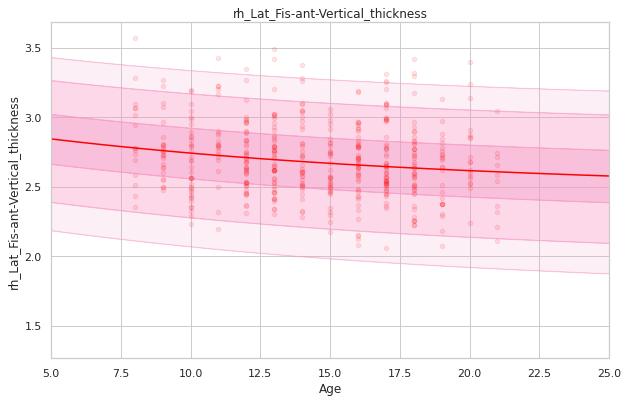

Running ROI 1 rh_Lat_Fis-post_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.15295817]), 'Rho': array([0.61579378]), 'pRho': array([0.]), 'SMSE': array([0.62124728]), 'EXPV': array([0.37919875])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


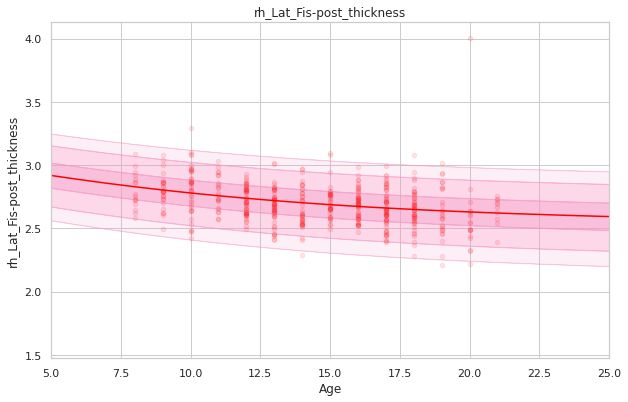

Running ROI 2 Left-Cerebellum-White-Matter :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3048.05193587]), 'Rho': array([0.38812997]), 'pRho': array([1.42966858e-119]), 'SMSE': array([0.85997252]), 'EXPV': array([0.14597987])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


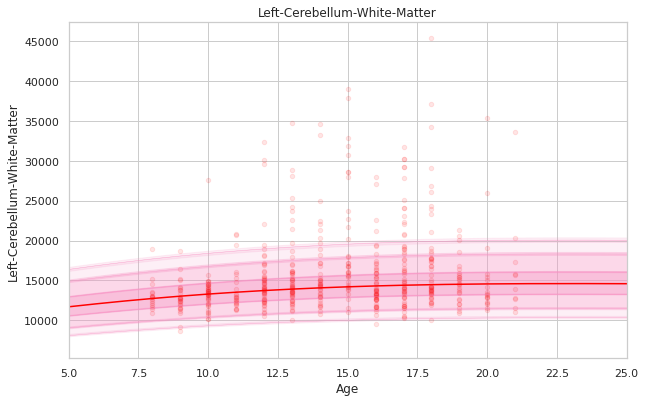

Running ROI 3 Right-Cerebellum-White-Matter :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([2627.77447993]), 'Rho': array([0.45671818]), 'pRho': array([1.98362377e-172]), 'SMSE': array([0.79511226]), 'EXPV': array([0.20619142])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


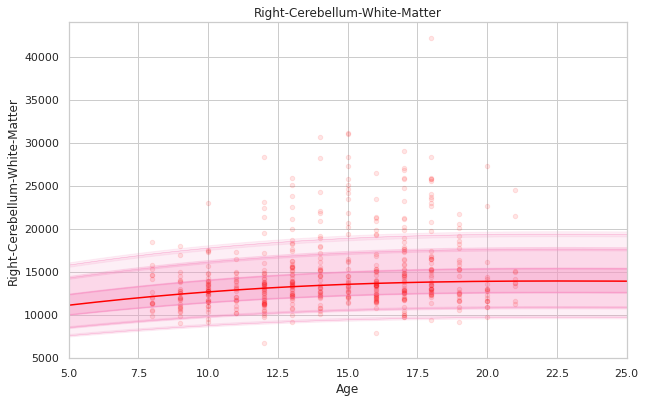

Running ROI 4 Right-vessel :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([22.83938848]), 'Rho': array([0.52378006]), 'pRho': array([5.94152837e-239]), 'SMSE': array([0.73692595]), 'EXPV': array([0.26990859])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


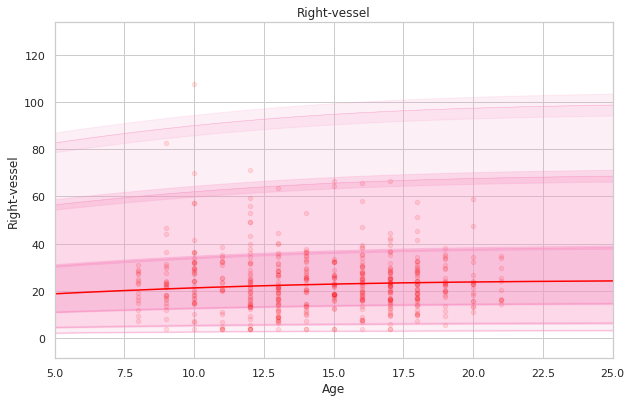

Running ROI 5 WM-hypointensities :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1753.28319618]), 'Rho': array([0.55752721]), 'pRho': array([2.13658479e-279]), 'SMSE': array([0.7477123]), 'EXPV': array([0.26597165])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


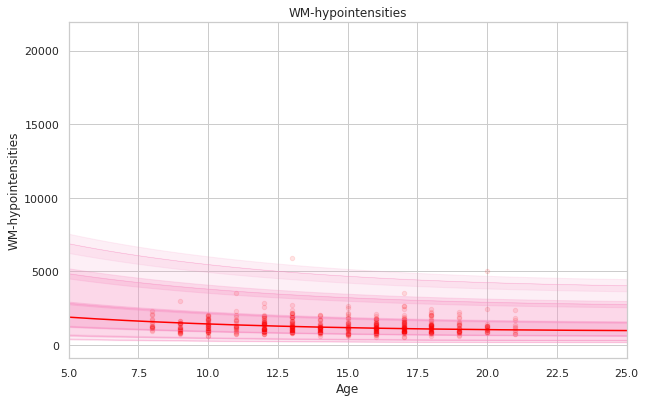

Running ROI 6 Optic-Chiasm :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([48.22460335]), 'Rho': array([0.73609812]), 'pRho': array([0.]), 'SMSE': array([0.46621577]), 'EXPV': array([0.54111173])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


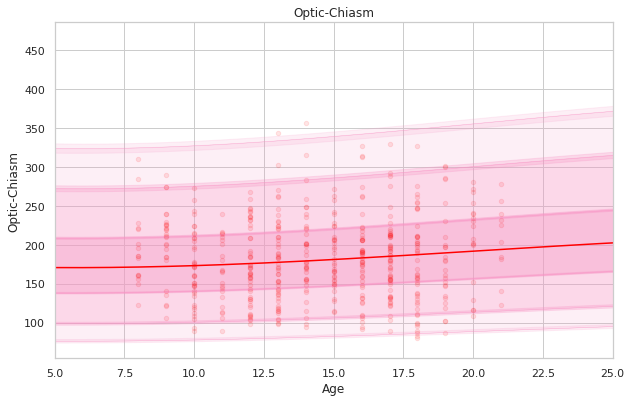

Running ROI 7 SurfaceHoles :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([30.11915239]), 'Rho': array([0.76709984]), 'pRho': array([0.]), 'SMSE': array([0.41448246]), 'EXPV': array([0.58837182])}


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Running on PhS dataset


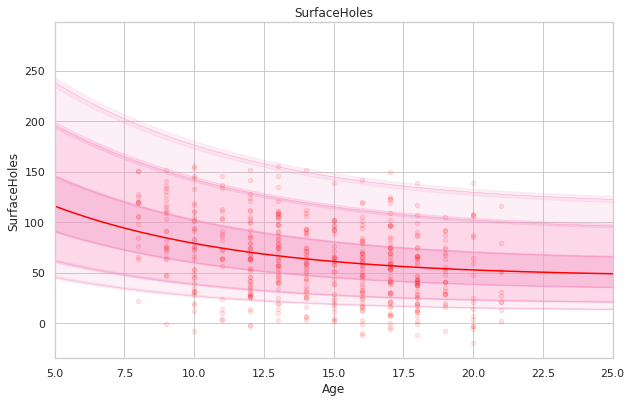

In [ ]:
# Read dummy file
sex = 1 # 0 = male 1 = female
roi_plot(roi_high_kur, sites = True, alpha = 0.1)

# Step 11: Check some ROI

In [ ]:
import pylab 
import scipy.stats as stats

## 1.Look at the ROI that have the max EV:

OLD code

ROI:  Right-choroid-plexus


,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
182,Right-choroid-plexus,130460.654572,0.703898,-0.526318,260960.956752,0.037174,0.346684


Run on this ROI: Right-choroid-plexus


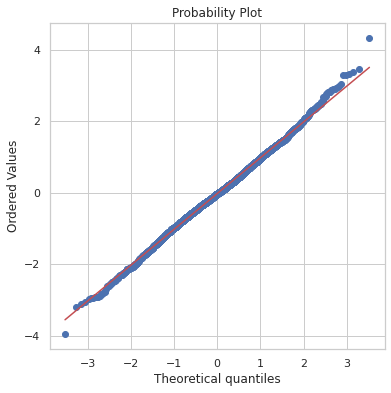

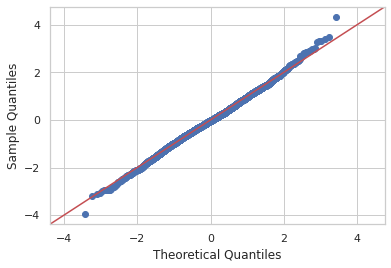

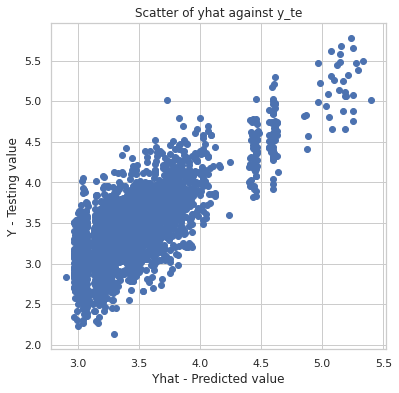

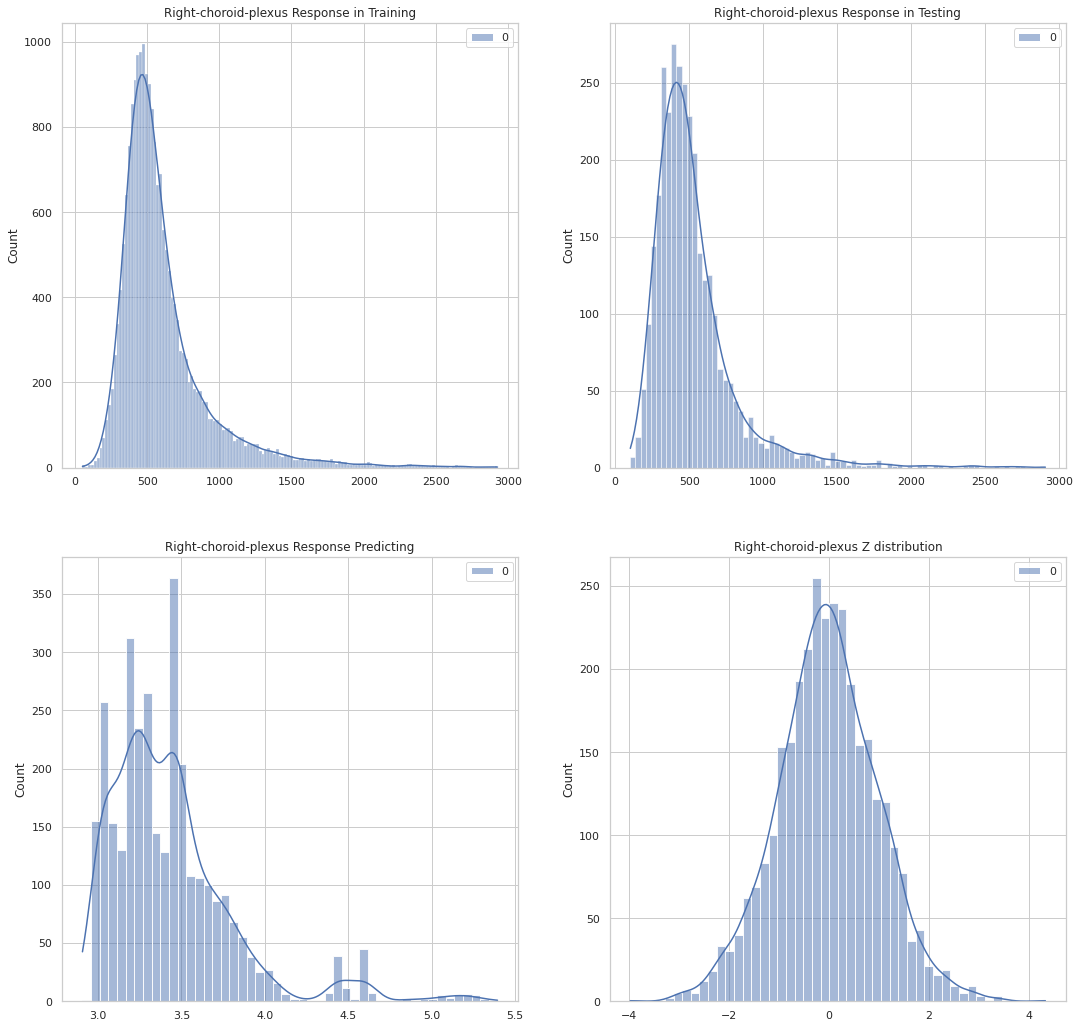

In [ ]:
# Old code
roi = blr_metrics[blr_metrics['EV'] == max(blr_metrics['EV'])].iloc[0,0]
print('ROI: ', roi)
display(blr_metrics[blr_metrics['eid']== roi])
suffix = 'estimate'

#random.seed(14)
if True: 
#for roi in (random.sample(ROI_id, 1)):
    print('Run on this ROI:', roi)
    roi_dir = os.path.join(model_dir,roi)
    Z_list = open(os.path.join(roi_dir, 'Z_' + suffix + '.txt')).read().split()
    with open(os.path.join(roi_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    # transfer to float
    Z_list = [float(i) for i in Z_list]

    fig = plt.subplots(ncols=1, figsize=(6,6))
    stats.probplot(Z_list, dist="norm", plot=pylab)
    Z = np.loadtxt(os.path.join(roi_dir, 'Z_' + suffix + '.txt'))
    sm.qqplot(Z, line = '45')
    plt.show()

    ### Plot values
    fig = plt.subplots(ncols=1, figsize=(6,6))
    y_tr = load_2d(os.path.join(roi_dir, 'resp_tr.txt'))
    y_te = load_2d(os.path.join(roi_dir, 'resp_te.txt'))
    yhat_te = load_2d(os.path.join(roi_dir, 'yhat_' + suffix + '.txt'))
    Z_estimate = load_2d(os.path.join(roi_dir, 'Z_' + suffix + '.txt'))
    #fig, my_grid = plt.subplots(ncols=1, figsize=(6,6))
    # load y_te_warp to set into same space
    with open(os.path.join(roi_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    y_te_warp = nm.blr.warp.f(y_te, warp_param)
    plt.scatter(yhat_te, y_te_warp)
    #plt.scatter(yhat_te,y_te)
    plt.title("Scatter of yhat against y_te")
    plt.xlabel("Yhat - Predicted value")
    plt.ylabel("Y - Testing value")
    plt.show()

    fig, my_grid = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
    g1 = sns.histplot(y_tr,  multiple="stack", kde=True, ax=my_grid[0,0])
    g1.set_title(roi + ' Response in Training')
    g2 = sns.histplot(y_te,  multiple="stack", kde=True, ax=my_grid[0,1])
    g2.set_title(roi + ' Response in Testing')
    g3 = sns.histplot(yhat_te,  multiple="stack", kde=True, ax=my_grid[1,0])
    g3.set_title(roi + ' Response Predicting')
    g4 = sns.histplot(Z_estimate,  multiple="stack", kde=True, ax=my_grid[1,1])
    g4.set_title(roi + ' Z distribution')
    plt.show()


In [ ]:
#Make colour
from scipy.stats import gaussian_kde

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def scatter_density(x, y, s):
  xy = np.vstack([x,y])
  z = gaussian_kde(xy)(xy)
  #fig, ax = plt.subplots()
  plt.scatter(x, y, c=z, s=s, cmap=white_viridis)
  plt.xlabel("Yhat - Predicted value")
  plt.ylabel("Y - Testing value")

def roi_check(roi):
#random.seed(14)
  if True: 
  #for roi in (random.sample(ROI_id, 1)):
      print('Run on this ROI:', roi)
      roi_dir = os.path.join(model_dir,roi)
      print('ROI: ', roi)
      display(blr_metrics[blr_metrics['eid']== roi])

      fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
      sns.set(style='whitegrid')
      suffix = 'estimate'
      # Hist plot
      Z_estimate = load_2d(os.path.join(roi_dir, 'Z_' + suffix + '.txt'))
      g1 = sns.histplot(Z_estimate, legend= False, multiple="stack", kde=True, ax=ax[0])
      g1.set_title(roi)

      # Z qqplot
      Z = np.loadtxt(os.path.join(roi_dir, 'Z_' + suffix + '.txt'))
      sm.qqplot(Z, line = '45', ax=ax[1])

      # Z histplot
      #yhat_te = load_2d(os.path.join(roi_dir, 'yhat_' + suffix + '.txt'))
      yhat_te = np.loadtxt(os.path.join(roi_dir, 'yhat_' + suffix + '.txt'))
      with open(os.path.join(roi_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
          nm = pickle.load(handle) 
      warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
      y_te = np.loadtxt(os.path.join(roi_dir, 'resp_te.txt'))
      y_te_warp = nm.blr.warp.f(y_te, warp_param)
      scatter_density(yhat_te, y_te_warp, 20)

Run on this ROI: Right-choroid-plexus
ROI:  Right-choroid-plexus


,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
182,Right-choroid-plexus,130460.654572,0.703898,-0.526318,260960.956752,0.037174,0.346684


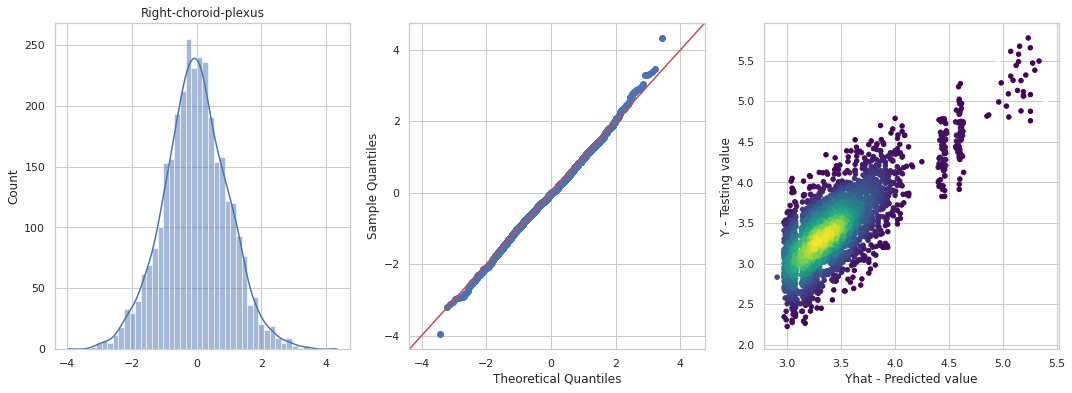

In [ ]:
# New code
roi = blr_metrics[blr_metrics['EV'] == max(blr_metrics['EV'])].iloc[0,0]
roi_check(roi)

## 2.Look at the ROI that have the min MSLL

Run on this ROI: Optic-Chiasm
ROI:  Optic-Chiasm


,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
186,Optic-Chiasm,108129.486763,0.541112,-0.660361,216298.624306,-1.065524,3.497369


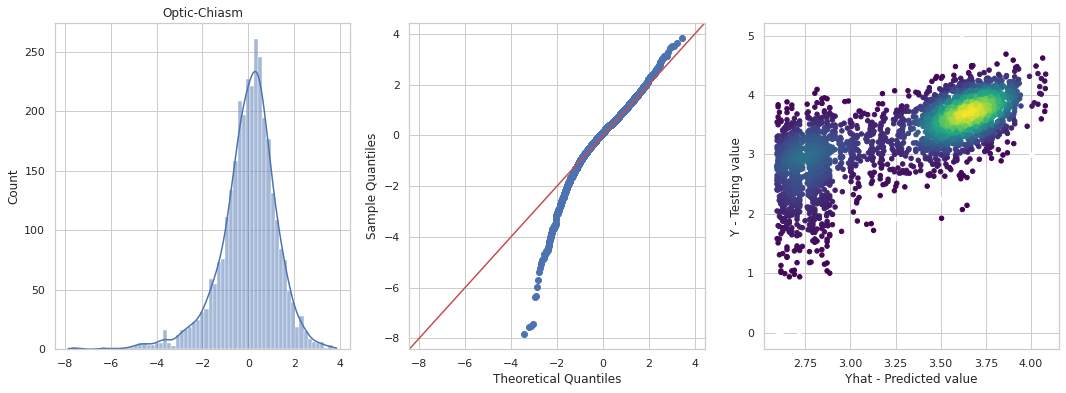

In [ ]:
roi = blr_metrics[blr_metrics['MSLL'] == min(blr_metrics['MSLL'])].iloc[0,0]
roi_check(roi)

## 3.Look at the ROI that have the max Kurtosis

Run on this ROI: Left-Cerebellum-White-Matter
ROI:  Left-Cerebellum-White-Matter


,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
153,Left-Cerebellum-White-Matter,180349.067473,0.14598,-0.050976,360737.783943,1.563073,5.338911


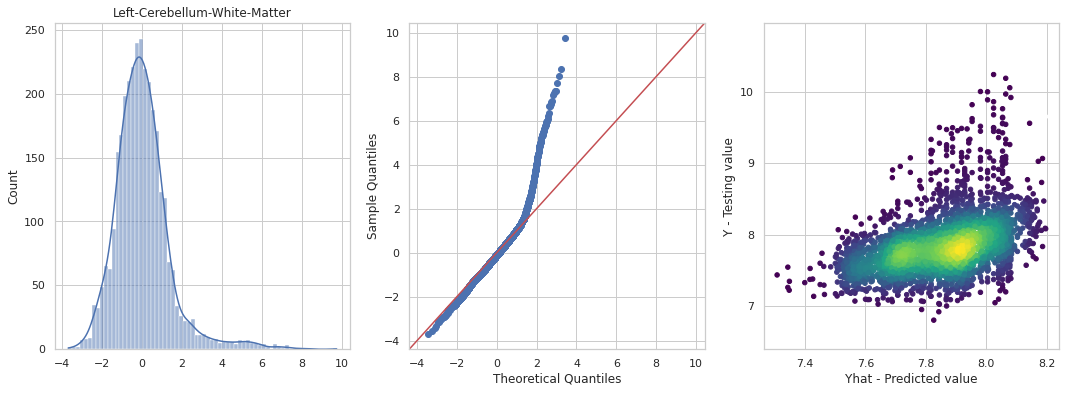

In [ ]:
roi = blr_metrics[blr_metrics['Kurtosis'] == max(blr_metrics['Kurtosis'])].iloc[0,0]
roi_check(roi)

As Kurtosis show a high value, this ROI is expected to contain some extreme Z-score:
1. qq-plot show that the Z-value of this ROI behave in a normal distribution. However, there are some Z-score are out of normal range.
2. Scatter plot show a trend in both testing and predicted value. :?But the units of these datapoint differ alot. There are some data point that are not follow the trend.
3. Both data in training, testing, Z-score reveal a normal distribution. Training, testing and Z-score show quite left skew. 
Predicting values seem not follow a normal distribution.

# 12.Check assumptions

## Check response variables vs predicting variable

Charlotte: To compare y_te with y_hat we need to bring them in the same space. So or in the warped 'Gaussian space" as we do down below or bring them both in the space of the original data.

QX: Taking from the script:

The hyperparameters are:

`hyp = ( log(beta), log(alpha) )  # hyp is a list or numpy array`

The implementation and notation mostly follows Bishop (2006).
The hyperparameter beta is the noise precision and alpha is the precision over lengthscale parameters. This can be either a scalar variable (a common lengthscale for all input variables), or a vector of length D (a different lengthscale for each input variable, derived using an automatic relevance determination formulation). These are estimated using conjugate gradient optimisation of the marginal likelihood.

gamma: parameters for warping the likelhood function

`gamma = hyp[n_lik_param:(n_lik_param + self.n_warp_param)]`
where: 

- n_warp_param: number of parameter of 'warp'

- n_lik_param is len of w_d array ~ vector of hyp

Running ROI 0 lhCortexVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([23887.69175609]), 'Rho': array([0.77505327]), 'pRho': array([0.]), 'SMSE': array([0.40029331]), 'EXPV': array([0.60029225])}


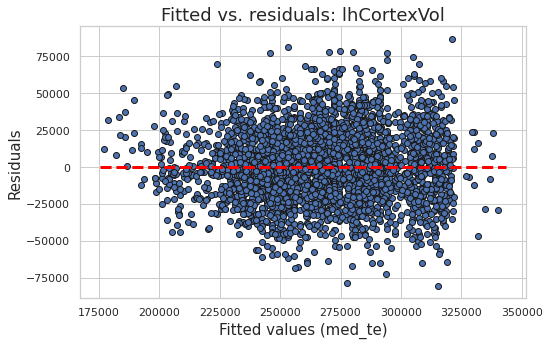

Running ROI 1 rh_S_oc-temp_med&Lingual_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.14375608]), 'Rho': array([0.6285752]), 'pRho': array([0.]), 'SMSE': array([0.60639843]), 'EXPV': array([0.39415781])}


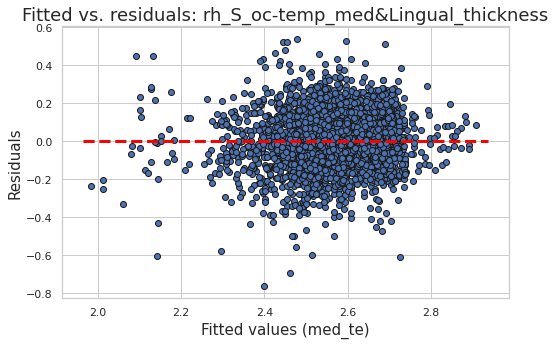

In [ ]:
random.seed(95)
for roi_num, roi in enumerate(random.sample(ROI_id, 2)): 
    print('Running ROI', roi_num, roi, ':')
    roi_dir = os.path.join(model_dir, roi)
    os.chdir(roi_dir) # Move to current IDP dir

    # Load predictive and  response variables generated by NM
    yhat_te = load_2d(os.path.join(roi_dir, 'yhat_estimate.txt'))
    s2_te = load_2d(os.path.join(roi_dir, 'ys2_estimate.txt'))
    y_te = load_2d(os.path.join(roi_dir, 'resp_te.txt'))

    # Choose only those belong to phs
    #y_te = y_te[:df_te_phs.shape[0]]
    #yhat_te = yhat_te[:df_te_phs.shape[0]]
    #s2_te = s2_te[:df_te_phs.shape[0]]

    ### set up the covariates for the dummy data 
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                        alg = 'blr', 
                        respfile = None,
                        model_path = os.path.join(roi_dir,'Models'), 
                        outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(roi_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle)
        
    # get the warp and warp parameters
    #param hyp: vector of hyperparmaters
    #gamma: parameters for warping the likelhood function
    W = nm.blr.warp 
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
    y_te_warp = nm.blr.warp.f(y_te, warp_param)
               
    ### MAKING WARP FUNCTIONS

    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0] 
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))
    
    resid = y_te - med_te
    plt.figure(figsize=(8,5))
    p=plt.scatter(x=med_te,y=resid,edgecolor='k')
    xmin=min(med_te)
    xmax = max(med_te)
    plt.hlines(y=0,xmin=xmin*0.99,xmax=xmax*1.01,color='red',linestyle='--',lw=3)
    plt.xlabel("Fitted values (med_te)",fontsize=15)
    plt.ylabel("Residuals",fontsize=15)
    plt.title(' '.join(('Fitted vs. residuals:',roi)), fontsize=18)
    plt.grid(True)
    plt.show()


# 13. Generate Z file

In [ ]:
from pathlib import Path

In [ ]:
data_dir = os.path.join(wBLR_dir,'data/')
data_dir

'/content/data/'

In [ ]:
os.listdir(model_dir)
z_dir = proc_dir + '/z_dir/'
os.makedirs(z_dir, exist_ok = True)

In [ ]:
%%capture
# Choose ROI pased blr qc:
ROI_blr = blr_metrics_qc['eid'].to_list()
for dirname in ROI_blr: # or os.listdir(model_dir):
    filename = model_dir + '/' + str(dirname) + '/Z_estimate.txt'
    path_check = Path(filename)
    if path_check.is_file():
        newname = z_dir + str(dirname) + '_Z_estimate.txt'
        shutil.copy(filename, newname)
    else:
        print(f'The file {filename} does not exist')

In [ ]:
with open('roi_blr.txt', 'w') as f:
    for item in ROI_blr:
        f.write("%s\n" % item)
len(ROI_blr)

199

In [ ]:
filelist = os.listdir(z_dir)

In [ ]:
os.chdir(z_dir)
# Add all z files into one Z_df
Z_df = pd.concat([pd.read_csv(item, names=[item[:-4]]) for item in filelist], axis=1)
# Add subject id
Z_df = pd.concat([df_te['participant_id'],Z_df], axis=1)
# Choose one those belonged to pnc (df_te_phs)):
Z_df = Z_df.head(df_te_phs.shape[0])

In [ ]:
# Cluster
Z_df.to_csv(os.path.join(proc_dir,'phs_blr_Z.csv'),index_label = True)

In [ ]:
Z_df

,participant_id,Right-Accumbens-area_Z_estimate,rh_G_pariet_inf-Angular_thickness_Z_estimate,Right-Cerebellum-White-Matter_Z_estimate,lh_MeanThickness_thickness_Z_estimate,lh_S_oc-temp_med&Lingual_thickness_Z_estimate,CSF_Z_estimate,rh_G&S_cingul-Ant_thickness_Z_estimate,lh_S_precentral-inf-part_thickness_Z_estimate,lh_G_temporal_inf_thickness_Z_estimate,...,4th-Ventricle_Z_estimate,lh_S_circular_insula_inf_thickness_Z_estimate,lh_G_oc-temp_med-Parahip_thickness_Z_estimate,lh_S_intrapariet&P_trans_thickness_Z_estimate,lh_G&S_cingul-Ant_thickness_Z_estimate,rh_S_intrapariet&P_trans_thickness_Z_estimate,lh_G_occipital_sup_thickness_Z_estimate,rh_G_cingul-Post-dorsal_thickness_Z_estimate,SupraTentorialVol_Z_estimate,lh_G_cingul-Post-dorsal_thickness_Z_estimate
0,sub-609312404588,-0.771493,0.761880,-1.639095,0.236432,0.584381,-1.412409,0.383516,1.486595,0.905054,...,-1.213884,-0.084800,-0.546442,0.236380,0.674481,0.104493,0.138306,0.398348,-1.126797,-1.337364
1,sub-608008202241,0.360353,0.710094,-0.066743,0.647051,0.794782,-0.263793,0.491883,0.686987,-0.181367,...,1.238435,1.353002,0.386087,-0.395226,0.223580,0.113307,-0.342600,1.240693,0.553448,-0.288097
2,sub-609200907432,-0.898422,-0.521688,-1.992299,-1.185753,-1.026777,0.046663,-0.306258,-0.682745,-0.778691,...,-0.790037,-2.094847,-1.326385,0.125662,-0.925249,-1.245262,-0.763499,-0.193996,-2.668379,-1.729490
3,sub-608457004492,0.549817,-0.965040,-2.402106,-1.648504,-1.406164,-0.367182,-1.873792,-0.868552,-1.395163,...,-0.568250,-1.031935,-1.527975,-0.838869,-1.435651,-0.541193,-0.367905,-0.985982,-1.351614,-1.575529
4,sub-602124114714,0.883001,-0.135232,0.252890,0.152134,-0.660636,-1.113417,1.034445,0.548615,0.507706,...,-0.147734,0.520417,1.174185,-0.924553,0.352400,0.239044,-0.422813,0.475610,-0.440385,-0.427389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,sub-602204357643,-0.295614,1.571740,-1.590947,1.453370,1.757454,-0.469299,2.983600,0.521419,-0.595347,...,-1.028846,0.111261,1.080720,1.031775,2.948217,0.554050,1.865746,0.159234,-1.030594,-0.324371
1006,sub-608353597581,0.438382,1.470735,0.672558,1.560018,0.883873,-0.703820,-0.468114,0.106295,2.102429,...,0.888246,0.418237,1.298066,0.824030,-0.849576,0.583963,1.893965,0.313387,0.035993,-0.195005
1007,sub-607138960013,1.266681,0.061631,-0.648039,-0.048963,-0.197009,-0.445084,-0.341975,-0.640474,-0.422938,...,-1.019907,0.880196,-0.630263,0.183378,0.250394,0.082442,-0.231309,-0.286585,-0.641890,1.236643
1008,sub-609262364081,-0.111176,-1.487679,-1.983377,-0.295101,-0.042227,-0.167849,0.997762,0.086175,-0.560919,...,-0.442604,-0.376726,-0.152930,-0.133211,1.192394,-0.062519,-1.334706,-0.277110,-1.122388,-1.141448


In [ ]:
# Colab
#Z_df.to_csv('/content/drive/MyDrive/wBLR-neuroPCN/data/Z_df.csv')
# Cluster
Z_df.to_csv(os.path.join(proc_dir,'phs_Z.csv'),index_label = True)

In [ ]:
os.chdir(wBLR_dir)
wBLR_dir

'/content/'

In [ ]:
%%capture
#%script false --no-raise-error
# Zip the file
! zip -r wBLR-NeuroImg.zip ./wBLR-NeuroImg

In [ ]:
# Import z-score
phs_z = pd.read_csv(os.path.join(proc_dir,'phs_Z.csv'))

#Z-score datasets:
# Remove first columns
phs_z.drop(columns=phs_z.columns[0], axis=1, inplace=True)
# Remove sub
phs_z['participant_id'] = phs_z['participant_id'].map(lambda x: x.lstrip('sub-'))
# Sort by subjects
phs_z = phs_z.sort_values(by ='participant_id')
# Reset index
phs_z.reset_index(drop=True, inplace=True)
# Set participant as index
phs_z.set_index('participant_id', inplace=True)
# Remove the tails Z_estimate
phs_z.columns = phs_z.columns.str.replace(r'_Z_estimate', '')

phs_z.to_csv(os.path.join(proc_dir,'phs_Z_EVT.csv'))
os.path.join(proc_dir,'phs_Z_EVT.csv')

phs_z

,Right-Accumbens-area,rh_G_pariet_inf-Angular_thickness,Right-Cerebellum-White-Matter,lh_MeanThickness_thickness,lh_S_oc-temp_med&Lingual_thickness,CSF,rh_G&S_cingul-Ant_thickness,lh_S_precentral-inf-part_thickness,lh_G_temporal_inf_thickness,rh_G_temp_sup-Lateral_thickness,...,4th-Ventricle,lh_S_circular_insula_inf_thickness,lh_G_oc-temp_med-Parahip_thickness,lh_S_intrapariet&P_trans_thickness,lh_G&S_cingul-Ant_thickness,rh_S_intrapariet&P_trans_thickness,lh_G_occipital_sup_thickness,rh_G_cingul-Post-dorsal_thickness,SupraTentorialVol,lh_G_cingul-Post-dorsal_thickness
participant_id,,,,,,,,,,,,,,,,,,,,,
600009963128,1.848758,-0.687790,1.126996,-0.129018,1.344876,0.719230,-0.730711,0.842792,0.490016,-1.031426,...,-1.403429,0.051593,-1.655902,0.865761,-0.741530,0.046557,-0.702499,0.443093,2.642350,0.595421
600018902293,-1.518550,-1.052189,-1.990382,-1.146150,0.160262,0.646025,-0.124889,-0.623011,-0.201713,-0.857179,...,0.942633,-0.698724,1.325218,-1.097358,-1.215093,-1.143833,-0.236253,-1.187356,-0.304339,-1.711438
600020364885,-0.435783,0.292252,-1.459993,0.759836,1.130537,0.459864,0.086290,1.214153,0.194107,0.335978,...,0.723279,0.135757,1.714871,-0.173734,-1.018872,-0.903582,0.903510,0.013064,1.077467,1.619949
600020927179,-0.329743,-1.567147,-1.671667,-0.862971,-0.740526,-0.429942,-0.788560,-0.284111,1.424441,-0.415901,...,0.811888,0.306058,1.003631,-0.640830,-1.472458,-1.590918,0.216949,-0.352463,-0.310640,-0.621670
600031697545,0.605349,-0.605990,-0.943827,-0.590314,0.116542,-0.177024,-0.359673,-1.073973,0.059532,-0.251363,...,1.569811,0.485460,0.447159,-1.012190,0.148999,-1.346234,-0.548520,-0.957999,-0.591730,-0.632619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609987242768,-0.041023,0.631019,4.859510,-0.121679,-0.390737,-0.030555,-0.314937,-0.096944,-0.011469,-1.058351,...,-0.840010,-0.782494,-0.247568,-0.069317,-0.739875,0.156047,0.510203,-0.494379,-0.761941,-0.504184
609987705265,-1.456713,-1.522021,-0.950611,-0.906842,-1.302882,1.213930,-0.547556,-0.072141,0.176746,0.731627,...,-1.146949,-0.517016,-0.851467,0.537736,-0.081493,-0.723542,-1.263610,-0.358108,1.242482,0.276533
609989574966,0.023963,-0.893021,-1.421802,-1.768486,-1.513901,1.040748,1.184219,-0.922416,-0.128569,-1.325444,...,0.841216,0.383390,-0.844963,0.330217,2.021810,-0.231531,0.210146,0.308375,-0.289960,0.791260
